# Module 4: Regime-based Simulations and Multi-Period Portfolio Models

In this module, we will introduce the concept of economic and market regimes, demonstrate the significance of regime identification, evaluate the performance of regime identification methods

## Table of Contents:
&nbsp;&nbsp;1. [Introduction to Economic Regimes](#1)

&nbsp;&nbsp;2. [Identification of Regimes: the Trend-Filtering Algorithm](#2)   

&nbsp;&nbsp;3. [A Regime-based Single Period Model](#3)   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 [Regime Identification: Parameter Estimation](#3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 [Scenario Simulation](#3.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 [Single-period Portfolio Model](#3.3)

&nbsp;&nbsp;4. [Application: Scenario-based Analysis of University Endowment](#4) 

&nbsp;&nbsp;5. [References](#5) 

## 1. Introduction to Economic Regimes <a class="anchor" id="1"></a>

A regime is a period of time in which the characteristics of market performance and related economic activity are reasonably stable. 

For better analysis of the market, we would like to catagorize historical periods into a small number of regimes and evaluate each regime separately.

Let us plot the historical performance of the US stock market index (S&P 500) with regimes that we have determined. You will learn how to determine the regimes later in this chapter, so hang tight with us.

In [1]:
#import all the necessary packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# ! python -m pip install cvxpy==1.0.29

import cvxpy as cp
import seaborn as sns
sns.set()
register_matplotlib_converters()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [2]:
# To import data successfully, change the folder to the directory of your data

#file_path = '~/Desktop/python_2018/Datasets/Assets_7.csv'
file_path = 'Assets_7.csv' 

asset_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])
asset_data.head()

C:\Users\jin_x\AppData\Local\Temp\ipykernel_31012\4107455781.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  asset_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])
C:\Users\jin_x\AppData\Local\Temp\ipykernel_31012\4107455781.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  asset_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])


,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
1985-01-01,3.69,443.231,100.0000,112.905,382.65,769.53,245.62,564.0916,0.30%,1,1,1
1985-02-01,3.99,455.868,101.9243,117.185,404.31,785.96,252.75,567.9944,-1.12%,1,1,1
1985-03-01,4.11,451.672,100.1330,118.672,410.96,774.00,246.33,571.6528,1.61%,1,1,1
1985-04-01,4.08,485.608,102.0311,119.185,408.20,802.77,251.11,575.8523,2.37%,1,1,1
1985-05-01,4.03,484.414,104.1377,121.356,408.57,774.58,256.72,579.6807,5.26%,1,1,1


Text(0.5, 0, 'Year')

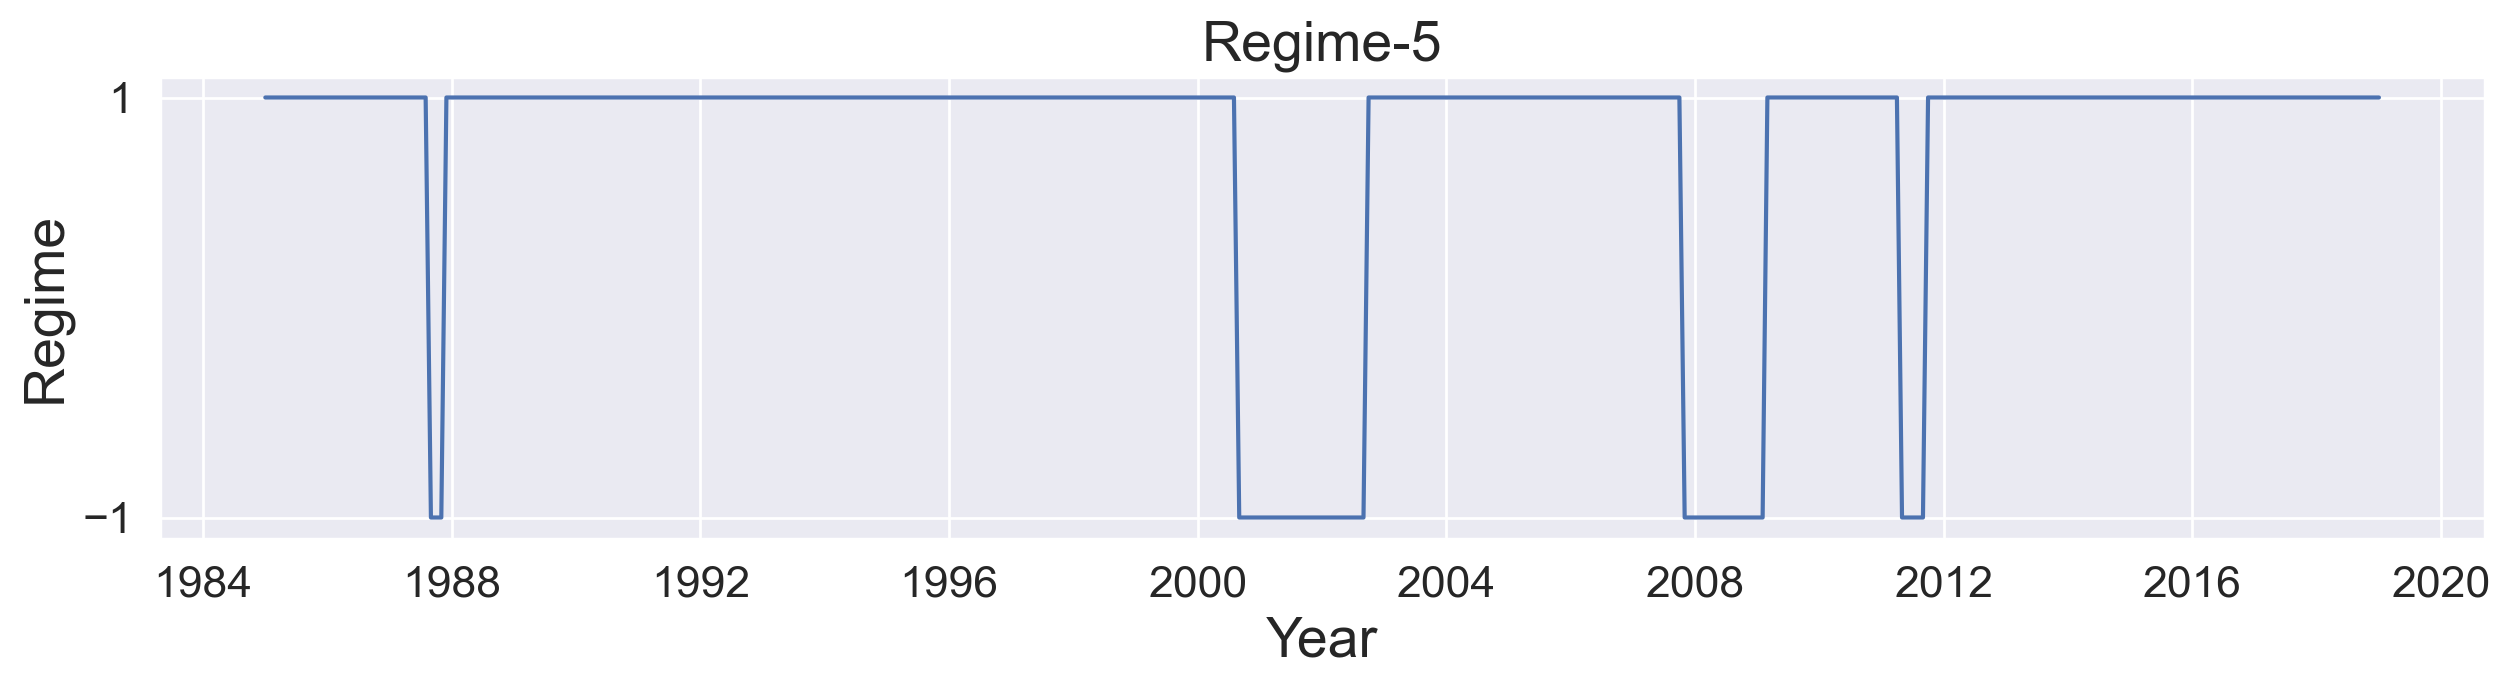

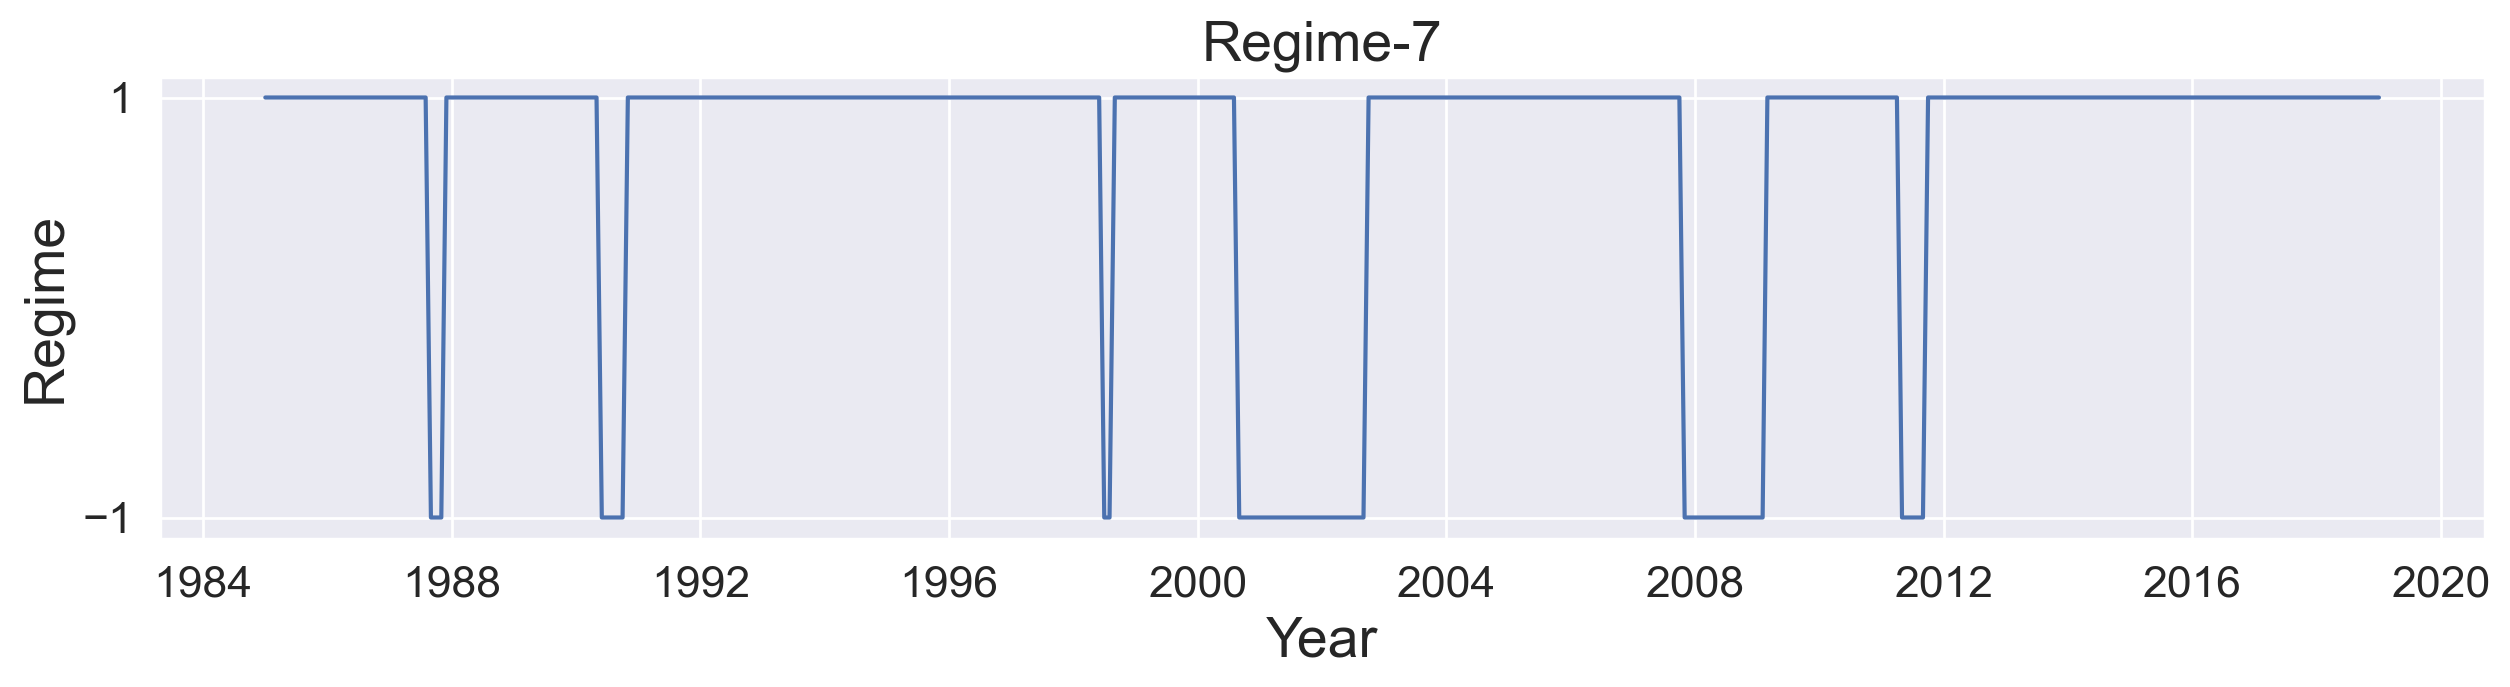

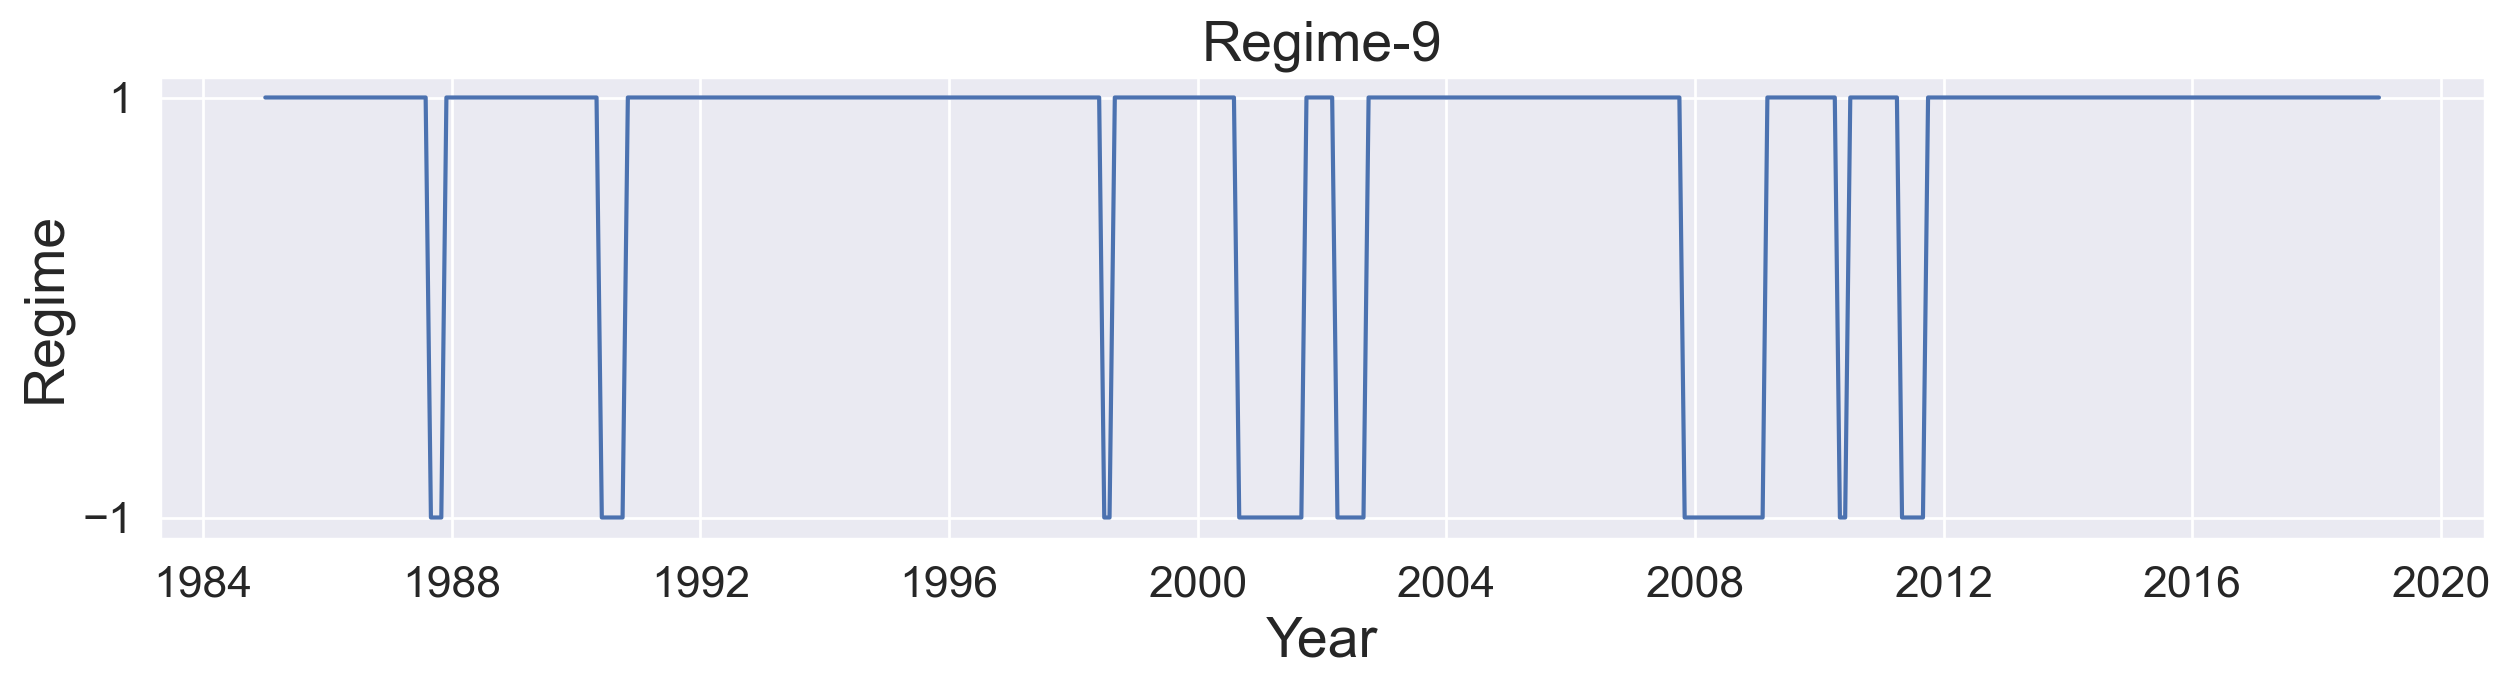

In [3]:
# Plot regimes. The method to generate this series will be shown in the section below

plt.figure(figsize=(15,3))
plt.plot(asset_data['Regime-5'])
plt.title('Regime-5',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')
plt.xlabel('Year')

plt.figure(figsize=(15,3))
plt.plot(asset_data['Regime-7'])
plt.title('Regime-7',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')
plt.xlabel('Year')

plt.figure(figsize=(15,3))
plt.plot(asset_data['Regime-9'])
plt.title('Regime-9',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')
plt.xlabel('Year')

In [4]:
# Functions for our analysis - feel free to edit
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def regime_return(asset_pd, column_number, regime_col):
    """Computes returns of a list of regime columns identified by number"""
    asset_name = asset_pd.columns[column_number]
    regime = asset_pd[regime_col].values[:-1]
    asset_return = np.diff(asset_pd[asset_name],axis=0) / asset_pd[asset_name].values[:-1,:]
    ret_g, ret_c = asset_return[regime==1,:], asset_return[regime==-1,:]
    return asset_return, ret_g, ret_c

def regime_hist(asset_pd, column_number, regime_col):
    """Plots the asset regimes with regime column identified by number"""
    asset_return, ret_g, ret_c = regime_return(asset_pd, column_number, regime_col)
    plt.hist(ret_g, bins=20, color='green', label='Growth Regime',alpha=0.3)
    plt.hist(ret_c, bins=15, color='red', label='Contraction Regime',alpha=0.3)
    plt.xlabel('Monthly Return')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')
    plt.title('Regime Histogram of Asset: ' + asset_name)
    return ret_g, ret_c

def Q_Q_plot(asset_data, column_num):
    plt.figure(figsize=(12,9))
    res = scipy.stats.probplot(ret[:,column_num], plot=plt)
    plt.title('Q-Q Plot of Asset: ' + asset_data.columns[column_num], fontsize=24)
    plt.ylabel('Returns')
    plt.show()
    
def regime_plot(asset_data, column_num):
    ret_g1 = ret_g[:,column_num]
    ret_c1 = ret_c[:,column_num]
    plt.figure(figsize=(12,9))
    plt.plot(ecdf(ret_g1)[0], ecdf(ret_g1)[1], color='green',label='Normal Regime')
    plt.plot(ecdf(ret_c1)[0], ecdf(ret_c1)[1], color='red',label='Crash Regime')
    plt.xlabel('Monthly Return')
    plt.ylabel('Cumulative Probability')
    plt.legend(loc='upper left')
    plt.title('Cumulative Density of Asset: ' + asset_data.columns[column_num], fontsize=24)
    plt.show()
    
def trend_filtering(data,lambda_value):
    '''Runs trend-filtering algorithm to separate regimes.
        data: numpy array of total returns.'''

    n = np.size(data)
    x_ret = data.reshape(n)

    Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
    D = Dfull[0:(n-1),]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)

    def tf_obj(x,beta,lambd):
        return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

    problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

    lambd.value = lambda_value
    problem.solve()

    return beta.value

def filter_plot(data,lambda_value,regime_num=0, TR_num=1):
    ret_sp = data.iloc[:,regime_num]
    sp500TR = data.values[:,TR_num]

    beta_value = trend_filtering(ret_sp.values,lambda_value)
    betas = pd.Series(beta_value,index=data.index)

    plt.figure(figsize=(12,9))
    plt.plot(ret_sp, alpha=0.4,label='Original Series')
    plt.plot(betas,label='Fitted Series')
    plt.xlabel('Year')
    plt.ylabel('Monthly Return (%)')
    plt.legend(loc='upper right')
    plt.show()
    
def regime_switch(betas,threshold=1e-5):
    '''returns list of starting points of each regime'''
    n = len(betas)
    init_points = [0]
    curr_reg = (betas[0]>threshold)
    for i in range(n):
        if (betas[i]>threshold) == (not curr_reg):
            curr_reg = not curr_reg
            init_points.append(i)
    init_points.append(n)
    return init_points

def plot_regime_color(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
    '''Plot of return series versus regime'''
    returns = dataset.iloc[:,regime_num]
    TR = dataset.iloc[:,TR_num]
    betas = trend_filtering(returns.values,lambda_value)
    regimelist = regime_switch(betas)
    curr_reg = np.sign(betas[0]-1e-5)
    y_max = np.max(TR) + 500
    
    if log_TR:
        fig, ax = plt.subplots()
        for i in range(len(regimelist)-1):
            if curr_reg == 1:
                ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                       facecolor='green', alpha=0.3)
            else:
                ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                       facecolor='red', alpha=0.5)
            curr_reg = -1 * curr_reg
        
        fig.set_size_inches(12,9)   
        plt.plot(TR, label='Total Return')
        plt.ylabel('SP500 Log-scale')
        plt.xlabel('Year')
        plt.yscale('log')
        plt.xlim([dataset.index[0], dataset.index[-1]])
        plt.ylim([80, 3000])
        plt.yticks([100, 500, 1000, 2000, 3000],[100, 500, 1000, 2000, 3000])
        plt.title('Regime Plot of SP 500', fontsize=24)
        plt.show()
        
def regime_switch_series(betas,threshold=1e-5):
    '''returns series of regime'''
    n = len(betas)
    save = np.zeros(n)
    for i in range(n):
        if (betas[i]>threshold):
            save[i] = 1
        else:
            save[i] = -1
    return save
        
def get_regime_series(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
    '''Plot of return series'''
    returns = dataset.iloc[:,regime_num]
    TR = dataset.iloc[:,TR_num]
    betas = trend_filtering(returns.values,lambda_value)
    regimeseries = regime_switch_series(betas)
    return regimeseries
        
def plot_regime_series(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
    '''Plot of return series'''
    returns = dataset.iloc[:,regime_num]
    TR = dataset.iloc[:,TR_num]
    betas = trend_filtering(returns.values,lambda_value)
    regimeseries = regime_switch_series(betas)
    plt.figure(figsize=(15,3))
    plt.plot(regimeseries)
    plt.yticks([-1,1])
    plt.ylabel('Regime')

def geo_return(X, input_type='Return'):
    """Computes geometric return for each asset"""
    if input_type == 'Return':
        X_geo = 1+X
        y = np.cumprod(X_geo,axis=0)
        return (y[-1,:]) ** (1/X.shape[0]) - 1
    else:
        return (X[-1,:] / X[0,:]) ** (1/(X.shape[0]-1)) - 1

def portfolio_opt(mu, Q, r_bar):
    w = cp.Variable(mu.size)
    ret = mu.T*w 
    risk = cp.quad_form(w, Q)
    prob = cp.Problem(cp.Minimize(risk), 
                   [cp.sum(w) == 1, w >= 0, ret >= r_bar])
    prob.solve()
    return np.round_(w.value,decimals=3)

def efficient_frontier_traditional(r_annual, Q_all, r_bar):

    n_asset = r_annual.size
    weight_vec = np.zeros((len(r_bar),n_asset))
    risk_port = np.zeros(len(r_bar))
    ret_port = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = r_annual.T*w_opt 
        risk_opt = cp.quad_form(w_opt, Q_all)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec[i,:] = w_opt.value
        ret_port[i] = ret_opt.value
        risk_port[i] = np.sqrt(risk_opt.value)

    plt.figure(figsize=(12,9))    
    plt.plot(risk_port*100, ret_port*100, 'xb-')
    plt.xlabel("Risk (%)")
    plt.ylabel("Nominal Return (%)")
    plt.title("Efficient Frontier: Single-Period", fontsize=24);
    
def efficient_frontier_scenario(r_all_1, r_bar):
    Q_1 = np.cov(r_all_1.T)
    mu_1 = np.mean(r_all_1, axis=0)
    
    efficient_frontier_traditional(mu_1, Q_1, r_bar)
    plt.title("Efficient Frontier: Single-Period, Scenario-Equivalent Version", fontsize=24);
    
def efficient_frontier_comparison(r_annual, Q_all, r_bar, n_scenarios=10000):
    n_asset = r_annual.size
    weight_vec = np.zeros((len(r_bar),n_asset))
    risk_port = np.zeros(len(r_bar))
    ret_port = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = r_annual.T*w_opt 
        risk_opt = cp.quad_form(w_opt, Q_all)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec[i,:] = w_opt.value
        ret_port[i] = ret_opt.value
        risk_port[i] = np.sqrt(risk_opt.value)
    
    plt.subplot(121)
    plt.plot(risk_port*100, ret_port*100, 'xb-')
    plt.xlabel("Risk (%)")
    plt.ylabel("Nominal Return (%)")
    plt.title("Traditional", fontsize=16);
    
    r_all_1 = np.random.multivariate_normal(r_annual.reshape(n_asset), Q_all, n_scenarios)

    Q_1 = np.cov(r_all_1.T)
    mu_1 = np.mean(r_all_1, axis=0)
    weight_vec1 = np.zeros((len(r_bar),n_asset))
    risk_port1 = np.zeros(len(r_bar))
    ret_port1 = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = mu_1.T*w_opt
        risk_opt = cp.quad_form(w_opt, Q_1)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec1[i,:] = w_opt.value
        ret_port1[i] = ret_opt.value
        risk_port1[i] = np.sqrt(risk_opt.value)  
        
    plt.subplot(122)
    plt.plot(risk_port1*100, ret_port1*100, 'xb-')
    plt.xlabel("Risk (%)")
    plt.title("Scenario-Equivalent", fontsize=16);
    
def efficient_frontier_twoRegime(ret, ret_g, ret_c, r_bar, n_scenarios = 10000):
    Q_all = np.cov(ret.T) * 12
    r_annual = (1+geo_return(ret)) ** 12 - 1
    r_annual = r_annual.reshape(-1,1)
    r_g = (1+geo_return(ret_g)) ** 12 - 1
    r_c = (1+geo_return(ret_c)) ** 12 - 1
    n_g = int(n_scenarios*ret_g.shape[0] / ret.shape[0])
    Q_g = np.cov(ret_g.T) * 12
    Q_c = np.cov(ret_c.T) * 12
    n_asset = r_annual.size

    s_1 = np.random.multivariate_normal(r_g, Q_g, n_g)
    s_2 = np.random.multivariate_normal(r_c, Q_c, n_scenarios-n_g)
    r_all_2 = np.vstack((s_1,s_2))

    Q_2 = np.cov(r_all_2.T)
    mu_2 = np.mean(r_all_2, axis=0)

    weight_vec2 = np.zeros((len(r_bar),n_asset))
    risk_port2 = np.zeros(len(r_bar))
    ret_port2 = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = mu_2.T*w_opt
        risk_opt = cp.quad_form(w_opt, Q_2)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec2[i,:] = w_opt.value
        ret_port2[i] = ret_opt.value
        risk_port2[i] = np.sqrt(risk_opt.value)

    efficient_frontier_traditional(r_annual, Q_all, r_bar)
    plt.plot(risk_port2*100, ret_port2*100, 'xr-',label='Two-Regime')
    plt.legend(loc='best', ncol=2, shadow=True, fancybox=True,fontsize=16)
    plt.title("Efficient Frontier: Single-Period, Traditional vs Two-Regime Version")
    plt.show()
    return r_all_2

# Endowment Simulation: still in progress
def regime_asset(n,mu1,mu2,Q1,Q2,p1,p2):
    s_1 = np.random.multivariate_normal(mu1, Q1, n).T
    s_2 = np.random.multivariate_normal(mu2, Q2, n).T
    regime = np.ones(n)
    for i in range(n-1):
        if regime[i] == 1:
            if np.random.rand() > p1:
                regime[i+1] = 0
        else:
            if np.random.rand() > p2:
                regime[i+1] = 0
    return (regime*s_1 + (1-regime)*s_2).T

def transition_matrix(regime):
    """Computes the transition matrix given the regime vector
    """
    n1,n2,n3,n4 = 0,0,0,0
    for i in range(len(regime)-1):
        if regime[i] == 1:
            if regime[i+1] == 1:
                n1 += 1
            else:
                n2 += 1
        else:
            if regime[i+1] == 1:
                n3 += 1
            else:
                n4 += 1
    return n1/(n1+n2), n2/(n1+n2), n3/(n3+n4), n4/(n3+n4)

def asset_simulation(assets_info, asset_num, regime_name, random_seed=777, n_scenarios=10000, n_years=50):
    """Simulates regime-based monthly returns.
    assets_info is a pandas Dataframe containing asset total return indices; please refer to the dataset for format.
    asset_num is the number of assets we would like to use. By default, this should be the first few columns in dataset.
    regime_name is the column name of regime in the dataset.
    
    Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
    """
    ret_all, ret_g, ret_c = regime_return(assets_info, np.arange(asset_num), 'Regime-5')
    regime = assets_info[regime_name].values[:-1] # lose 1 value from computing returns
    p1, _, p2, _ = transition_matrix(regime)
    mu1 = 1+geo_return(ret_g)
    mu2 = 1+geo_return(ret_c)
    Q1 = np.cov(ret_g.T)
    Q2 = np.cov(ret_c.T)
    r_all = np.zeros((n_years*12, asset_num, n_scenarios))
    
    np.random.seed(random_seed)
    for i in range(n_scenarios):
        r_all[:,:,i] = regime_asset(n_years*12,mu1,mu2,Q1,Q2,p1,p2)
    return r_all

def fund_simulation(holdings, asset_return, hold_type='fixed',spending_rate=0.03):
    """Simulates monthly data of a fund for a certain number of years.
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix
    if hold_type is a number, this is rebalance frequency (in months) 
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted (to be implemented...)
    
    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    
    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path
        
    elif type(hold_type)==int:
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path
    
    else: # "Dynamic" -- to be implemented
        return 0

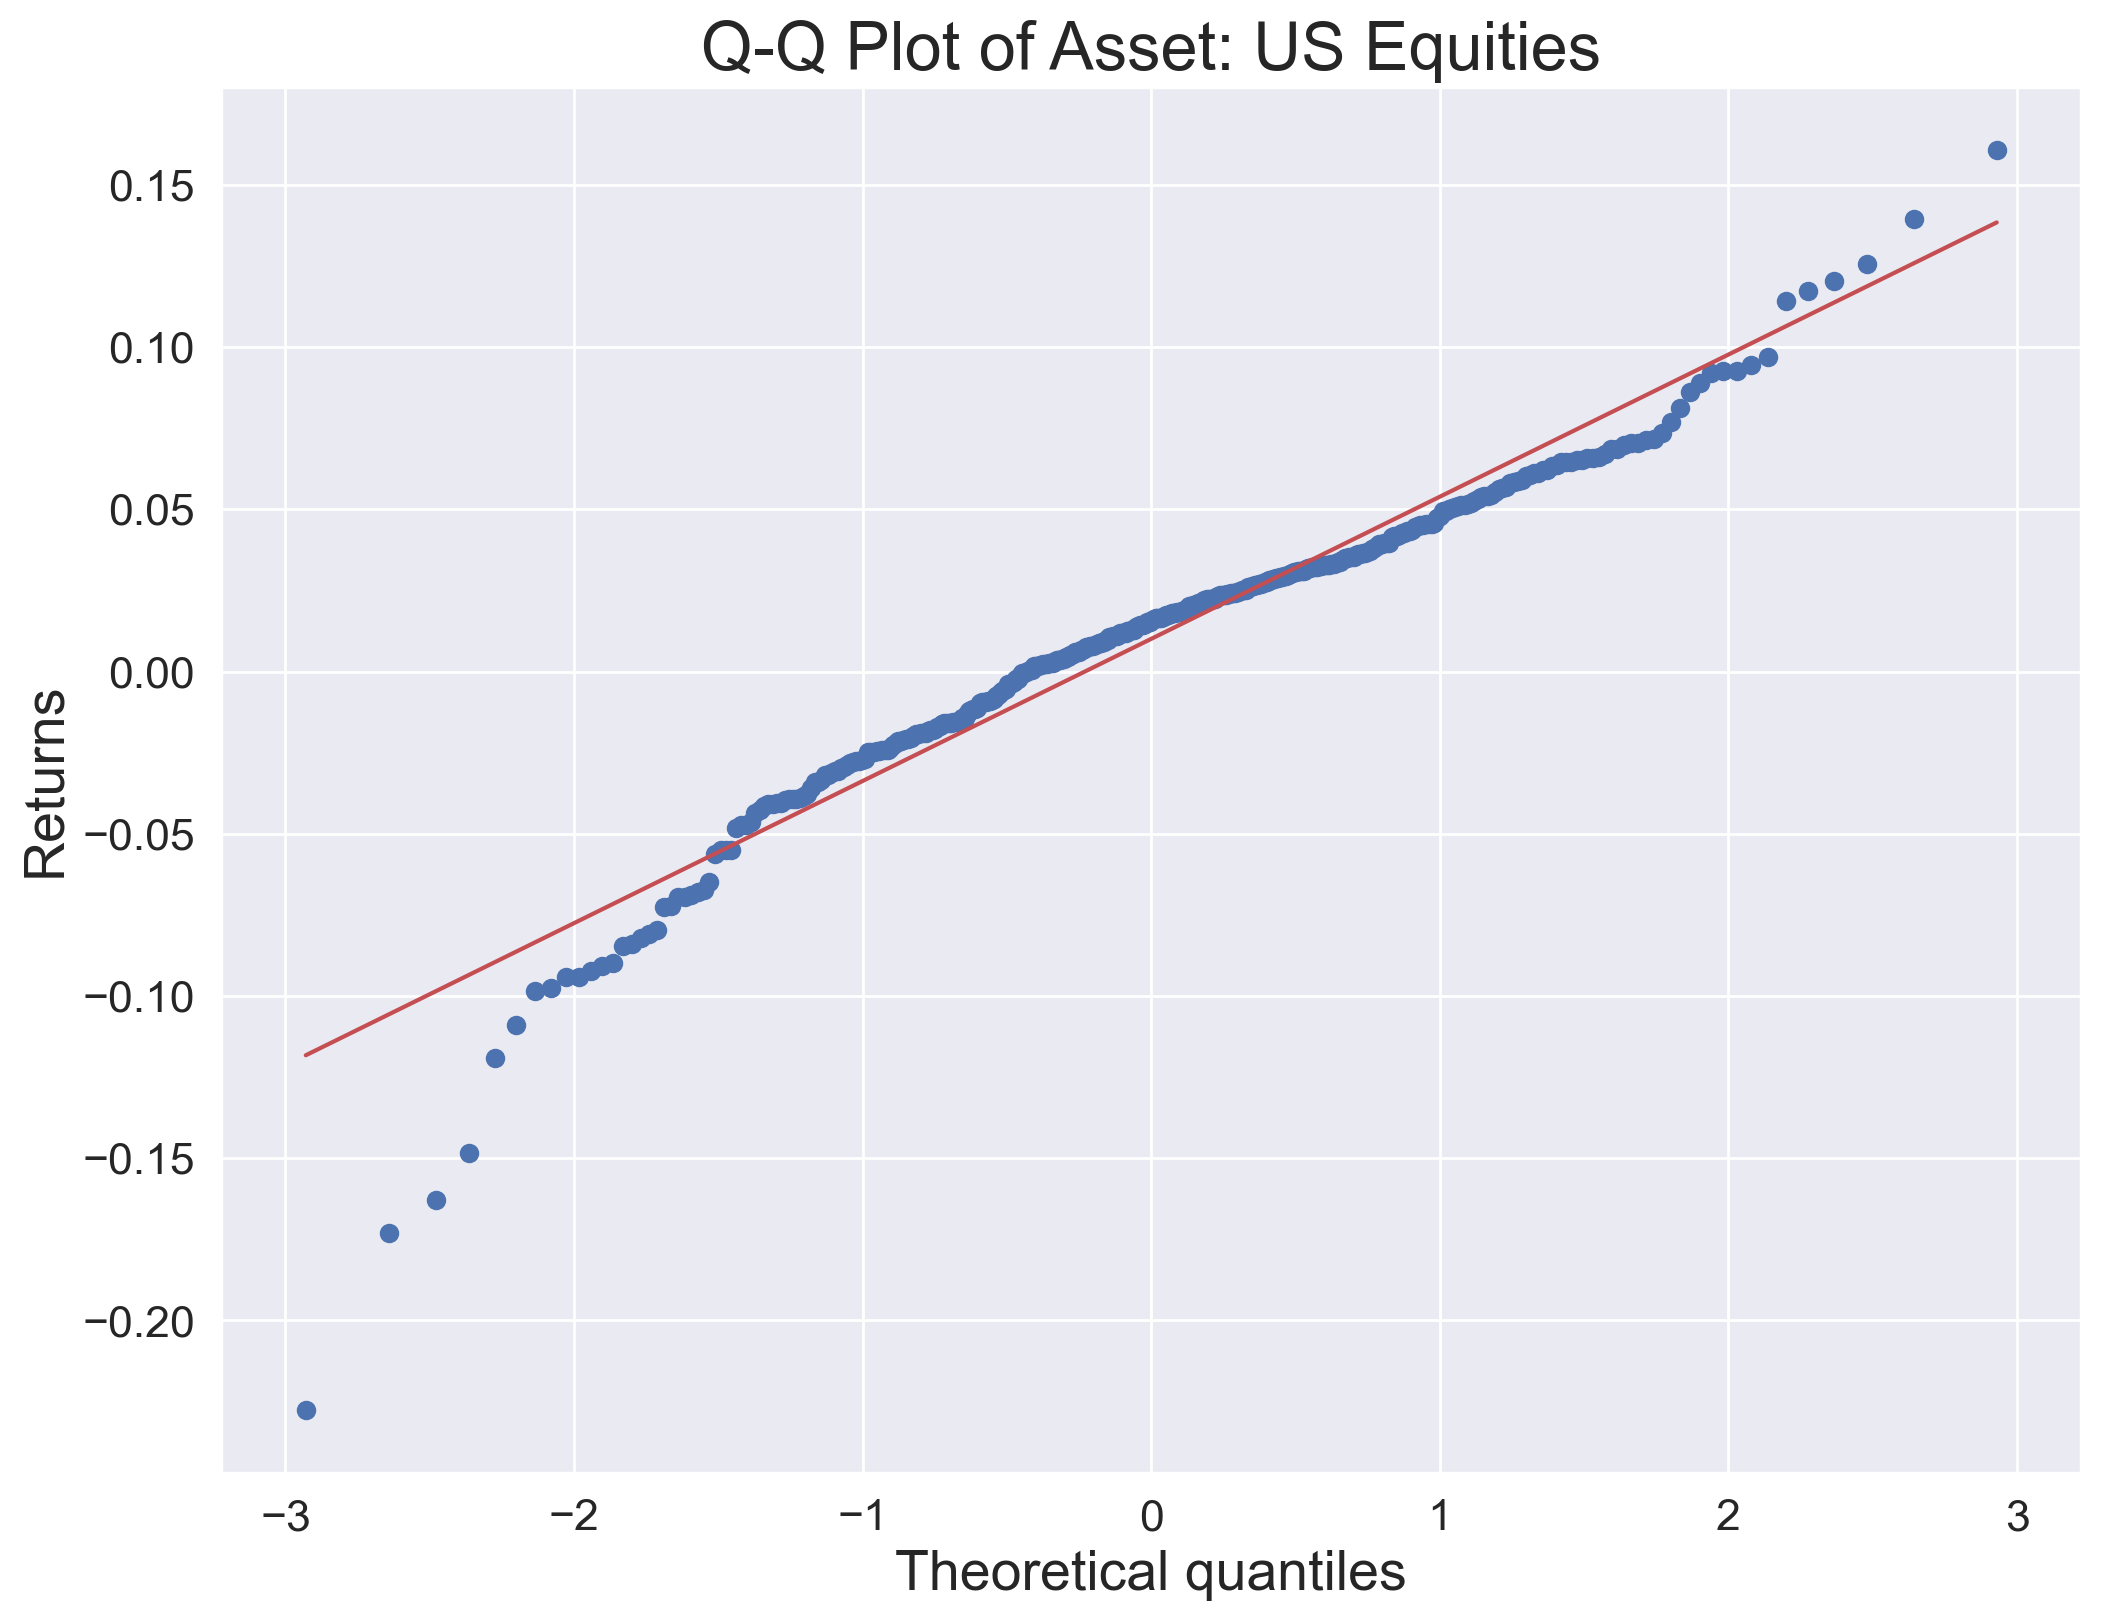

In [5]:
asset_index = [0,1,2,3,4,5,6,7]
ret, ret_g, ret_c = regime_return(asset_data, asset_index, 'Regime-5')

Q_Q_plot(asset_data, 0)

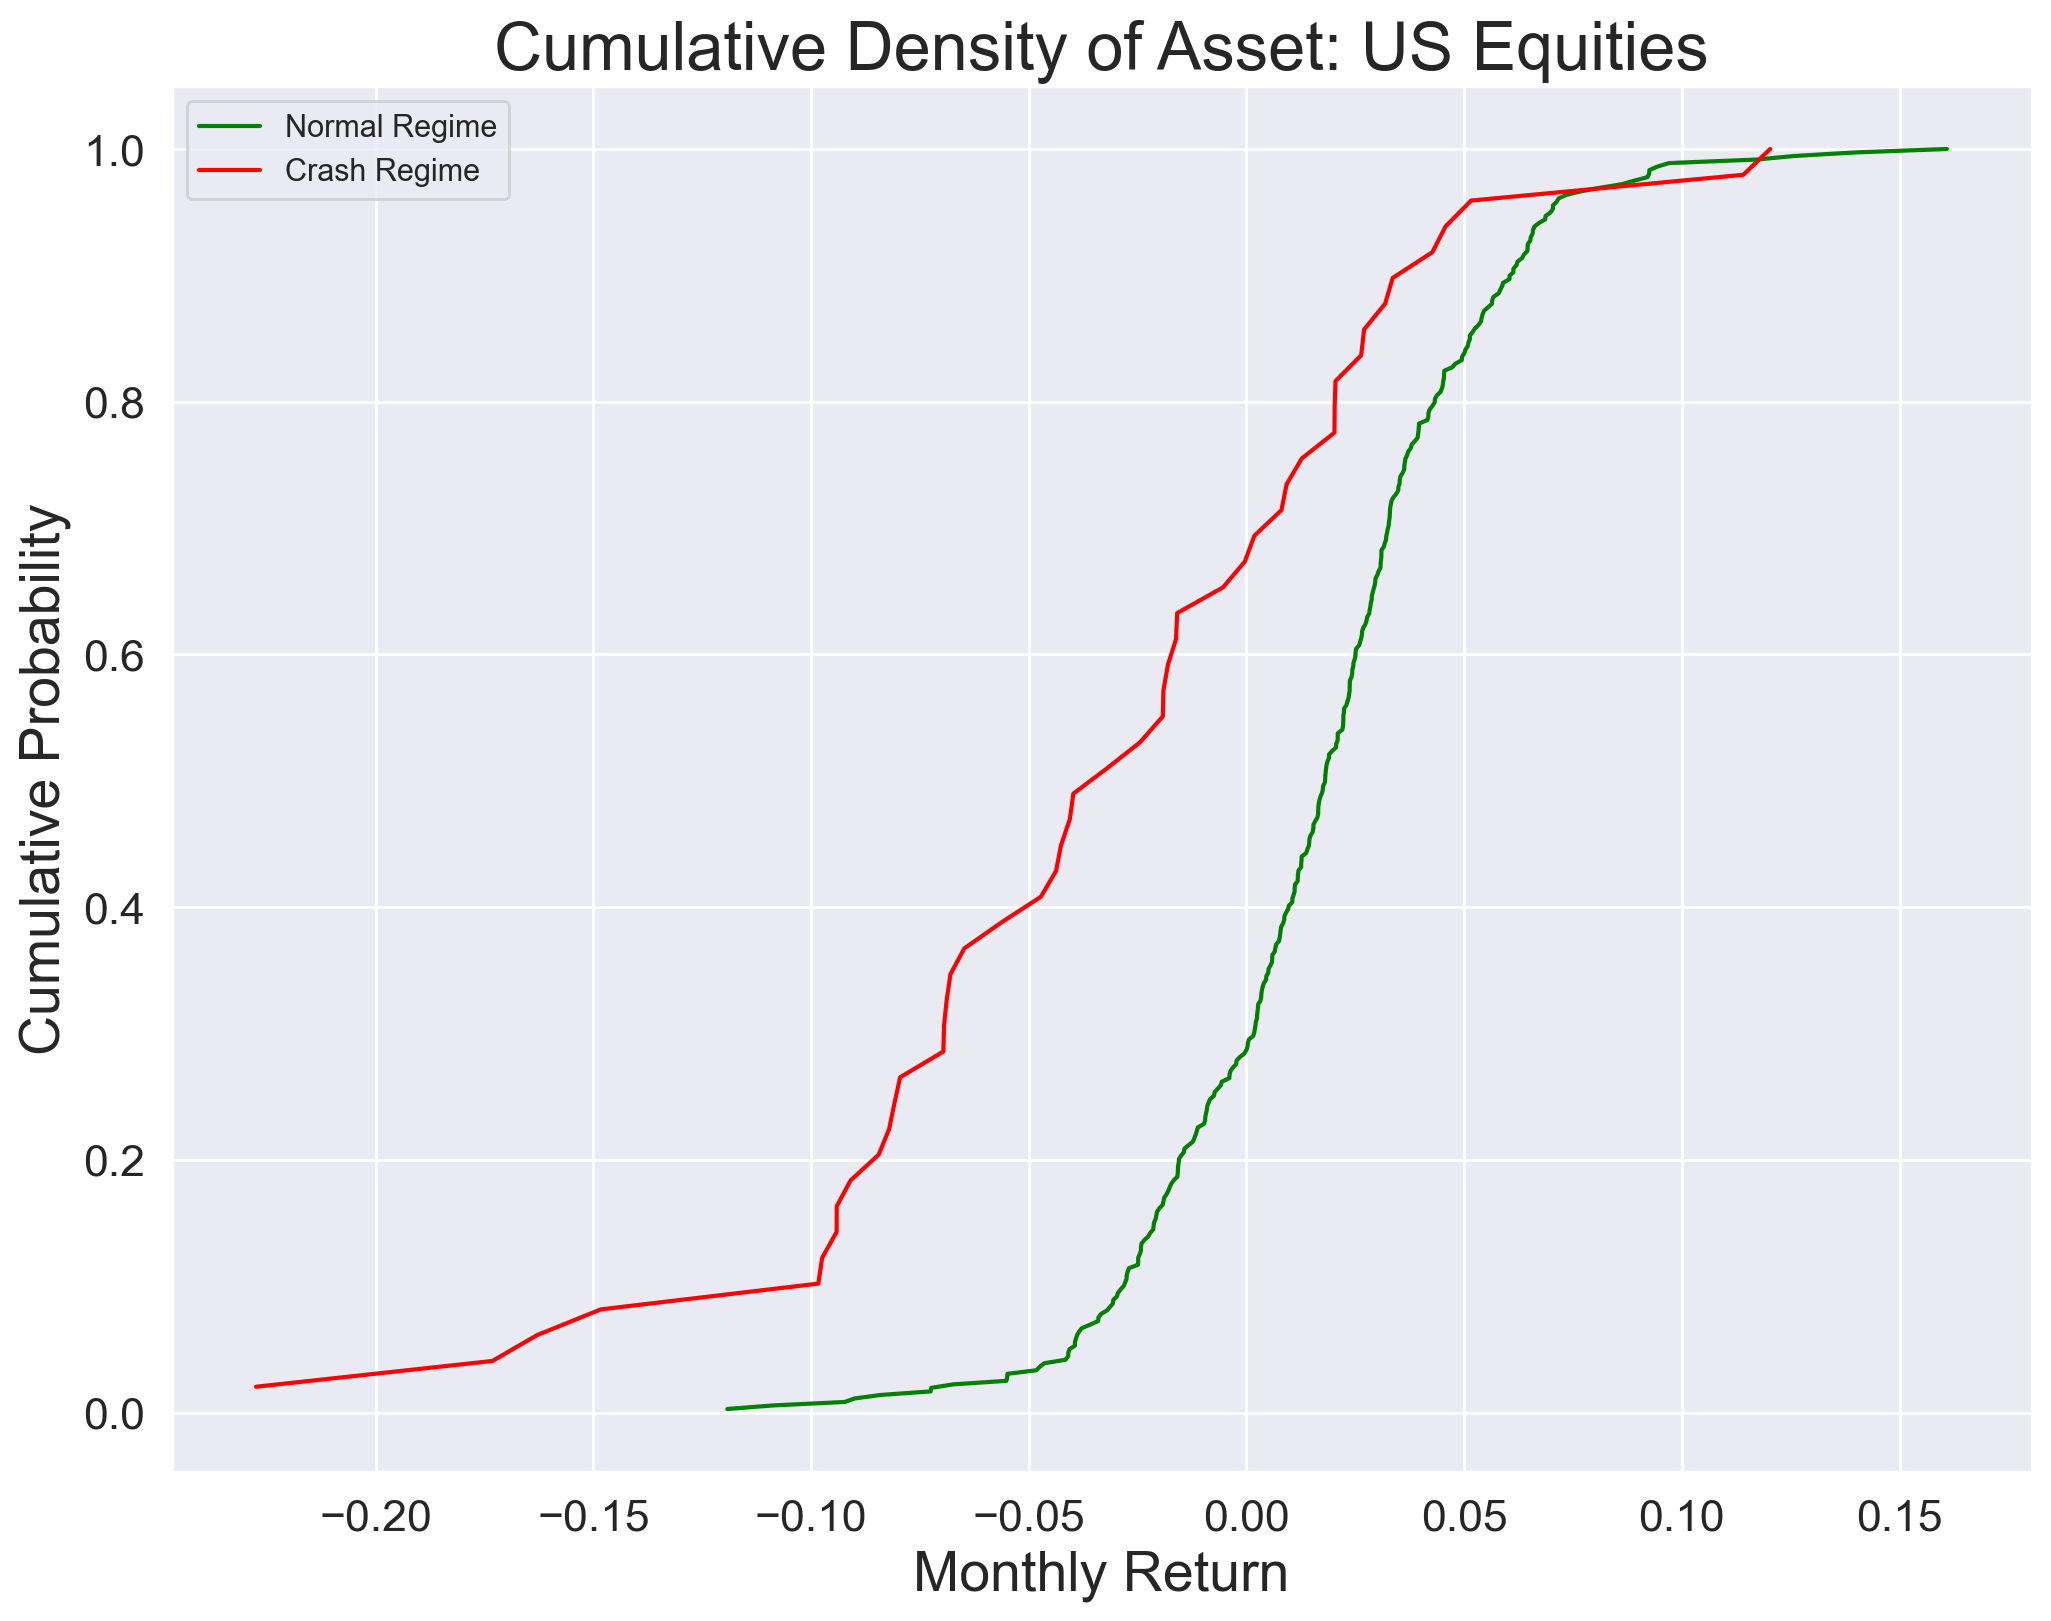

In [6]:
regime_plot(asset_data, 0)

We can observe that the monthly return distribution of World Equities is very different under growth regime or contraction regime. 

Now it's your turn to try more assets and compare their performance.

## 2. Identification of Regimes <a class="anchor" id="2"></a>

A regime analysis is significant in asset allocation and asset-liability management for long-term investors because of the contagion and related effects during crash periods: the correlation between risky assets and volatility will greatly increase during the crash periods, thus creating severe difficulty in risk management and protecting investor capital with traditional portfolio models.


Many existing methods are based on econometric models which assume a fixed structural model. However, financial return or macroeconomic data tends to be noisy and affected by myriad of factors. The state-of-the-art approach discussed in Mulvey and Liu (2016), trend-filtering, is non-parametric, data-driven and model-free. The algorithm was first introduced by Kim et al. (2009) and generalised in Tibshirani (2014).

In this part, we will implement the algorithm to obtain regimes of U.S. equity. First, we need the relevant packages and data.

In [7]:
# Import Data
file_path = 'SP500.csv'

SP500_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])
SP500_data.head()

C:\Users\jin_x\AppData\Local\Temp\ipykernel_31012\2649751744.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  SP500_data = pd.read_csv(file_path,index_col=0, header=0,parse_dates=[0])


,SP500,SP500TR
DATE,,
1985-01-01,0.5585,84.7932
1985-02-01,7.4747,91.1312
1985-03-01,5.5791,96.2155
1985-04-01,-1.1260,95.1321
1985-05-01,5.3201,100.1932


In the trend-filtering algorithm, we manage to find some ‘fitted’ time series that serves as the signal of the trend. This new time series can be obtained by solving the following optimizationproblem:

\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

where

\begin{equation*} 
D =
    \begin{bmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}.
\end{equation*}

Let's take a look at our $\beta$ values versus the original SP500 total returns:

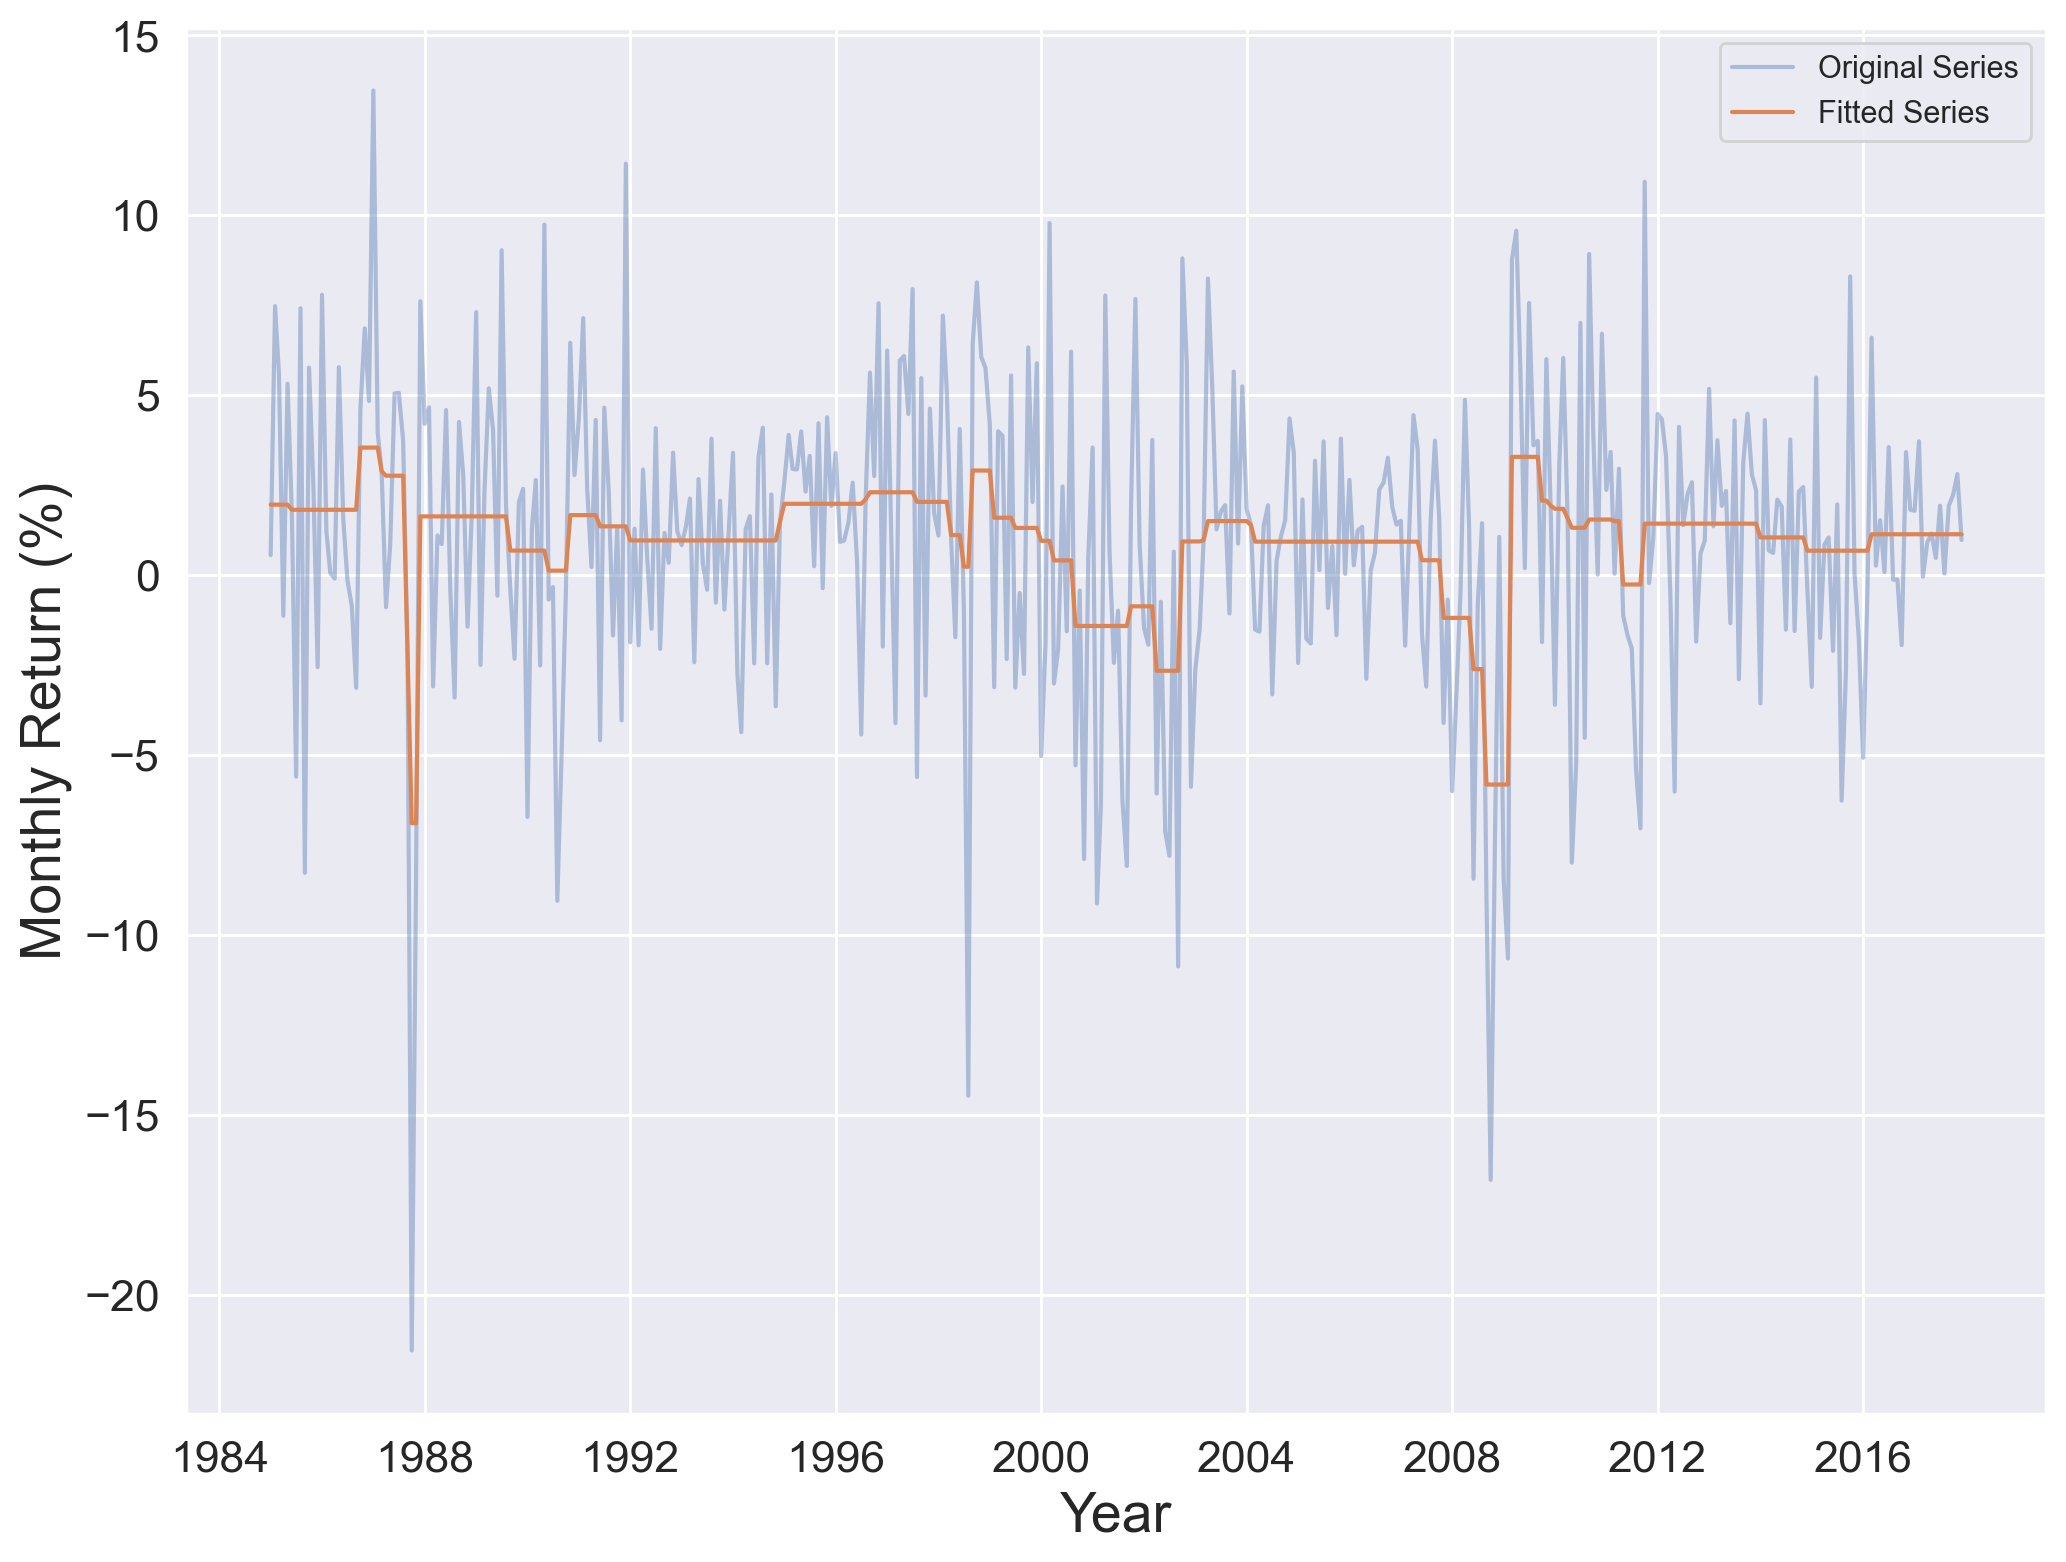

In [8]:
filter_plot(SP500_data,lambda_value=16)

The selection of $\lambda$ can be done with people's knowledge. We can plot the regimes with different $\lambda$ and choose the best one. Empirically, there will be fewer regimes with larger $\lambda$ because it prevent $\beta$ from changing, and vice versa. We need to make a balance and avoid both too sparse or too dense regime changes.

In [9]:
# Generate the regime series as we have shown above

df_regime = pd.DataFrame()
df_regime['Regime-5'] = get_regime_series(SP500_data, lambda_value=16)
df_regime['Regime-7'] = get_regime_series(SP500_data, lambda_value=14)
df_regime['Regime-9'] = get_regime_series(SP500_data, lambda_value=10)

df_regime.head()

,Regime-5,Regime-7,Regime-9
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


Text(0, 0.5, 'Regime')

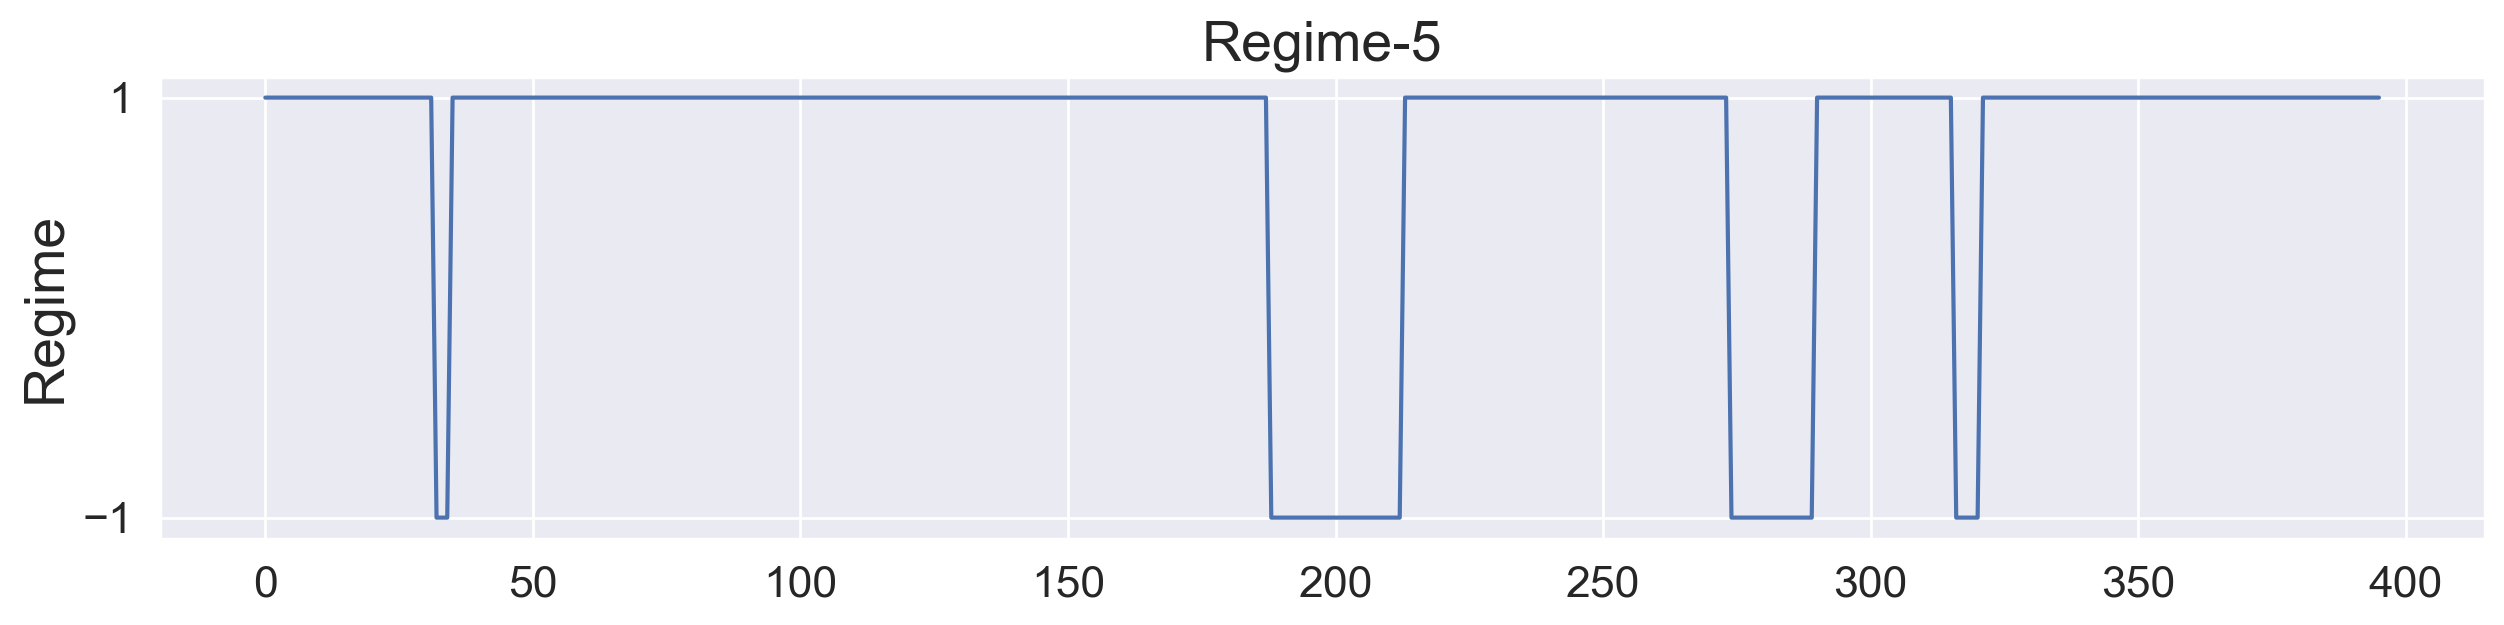

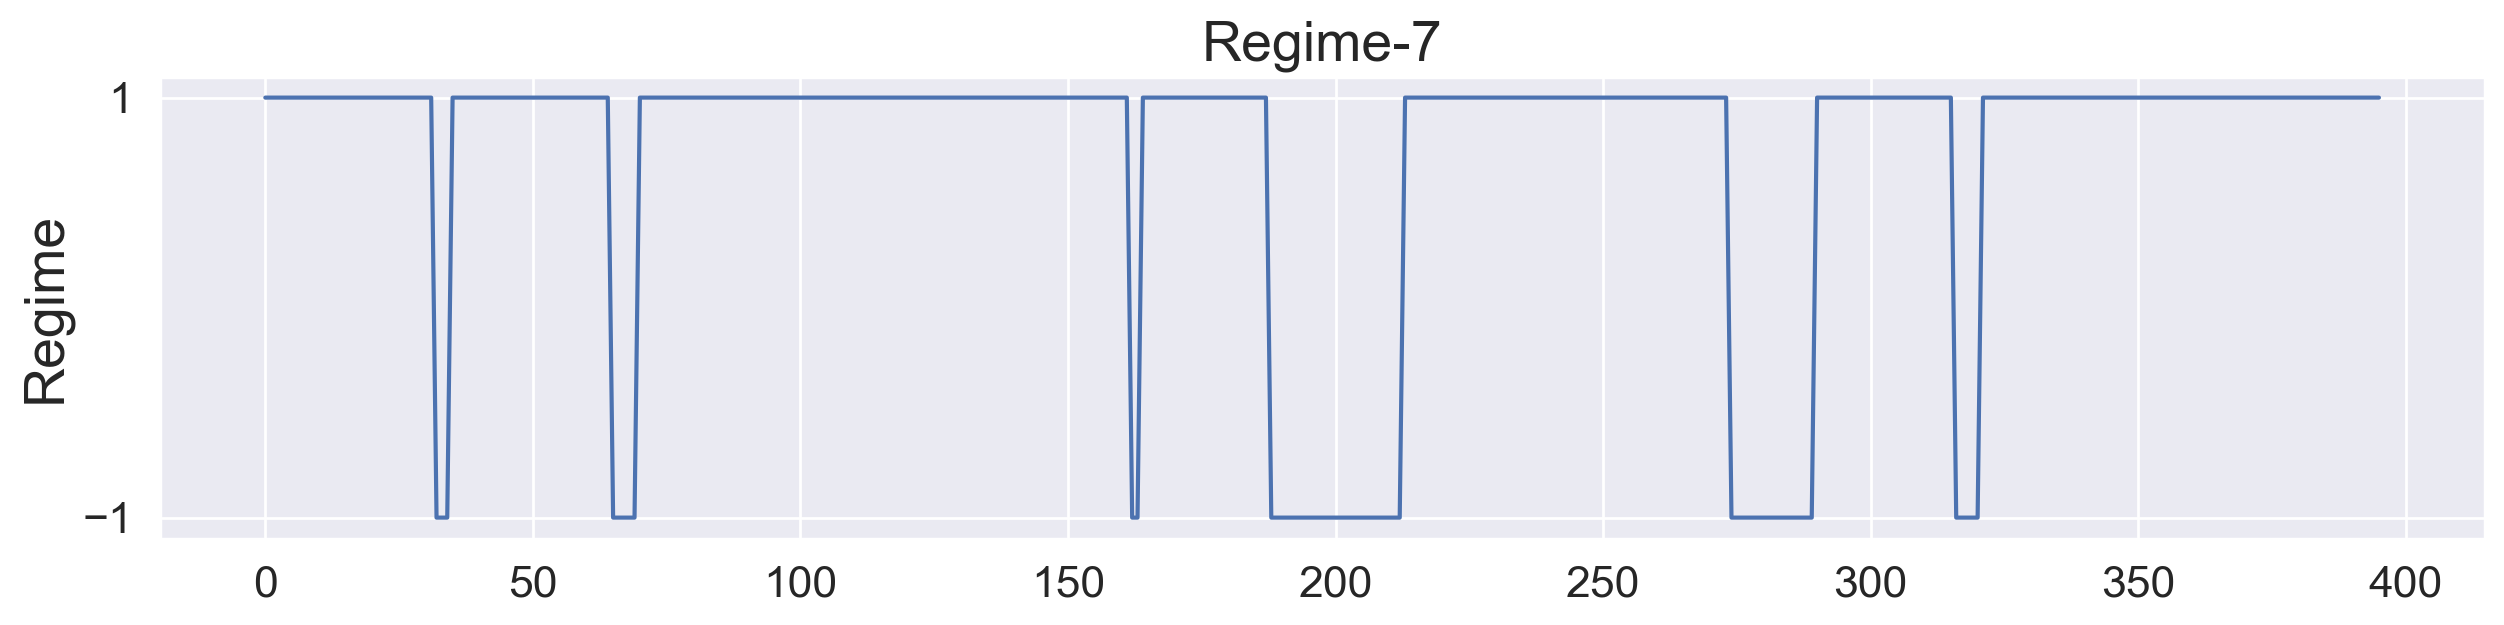

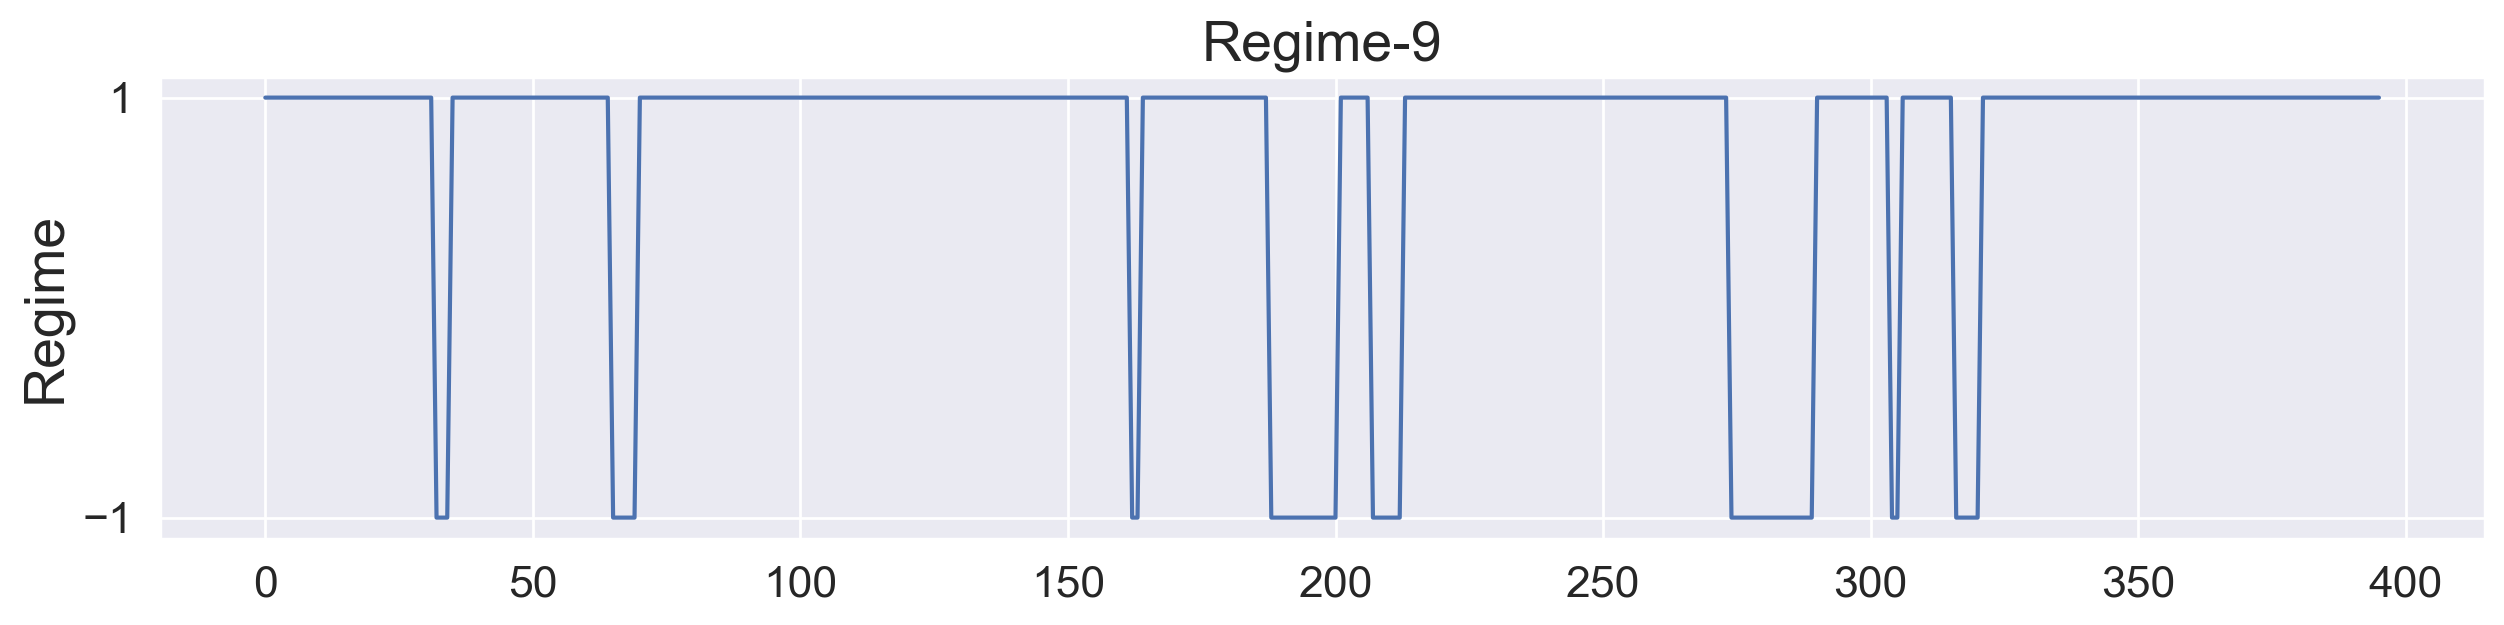

In [10]:
# Plot the regime series

plt.figure(figsize=(15,3))
plt.plot(df_regime['Regime-5'])
plt.title('Regime-5',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')

plt.figure(figsize=(15,3))
plt.plot(df_regime['Regime-7'])
plt.title('Regime-7',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')

plt.figure(figsize=(15,3))
plt.plot(df_regime['Regime-9'])
plt.title('Regime-9',size=20)
plt.yticks([-1,1])
plt.ylabel('Regime')

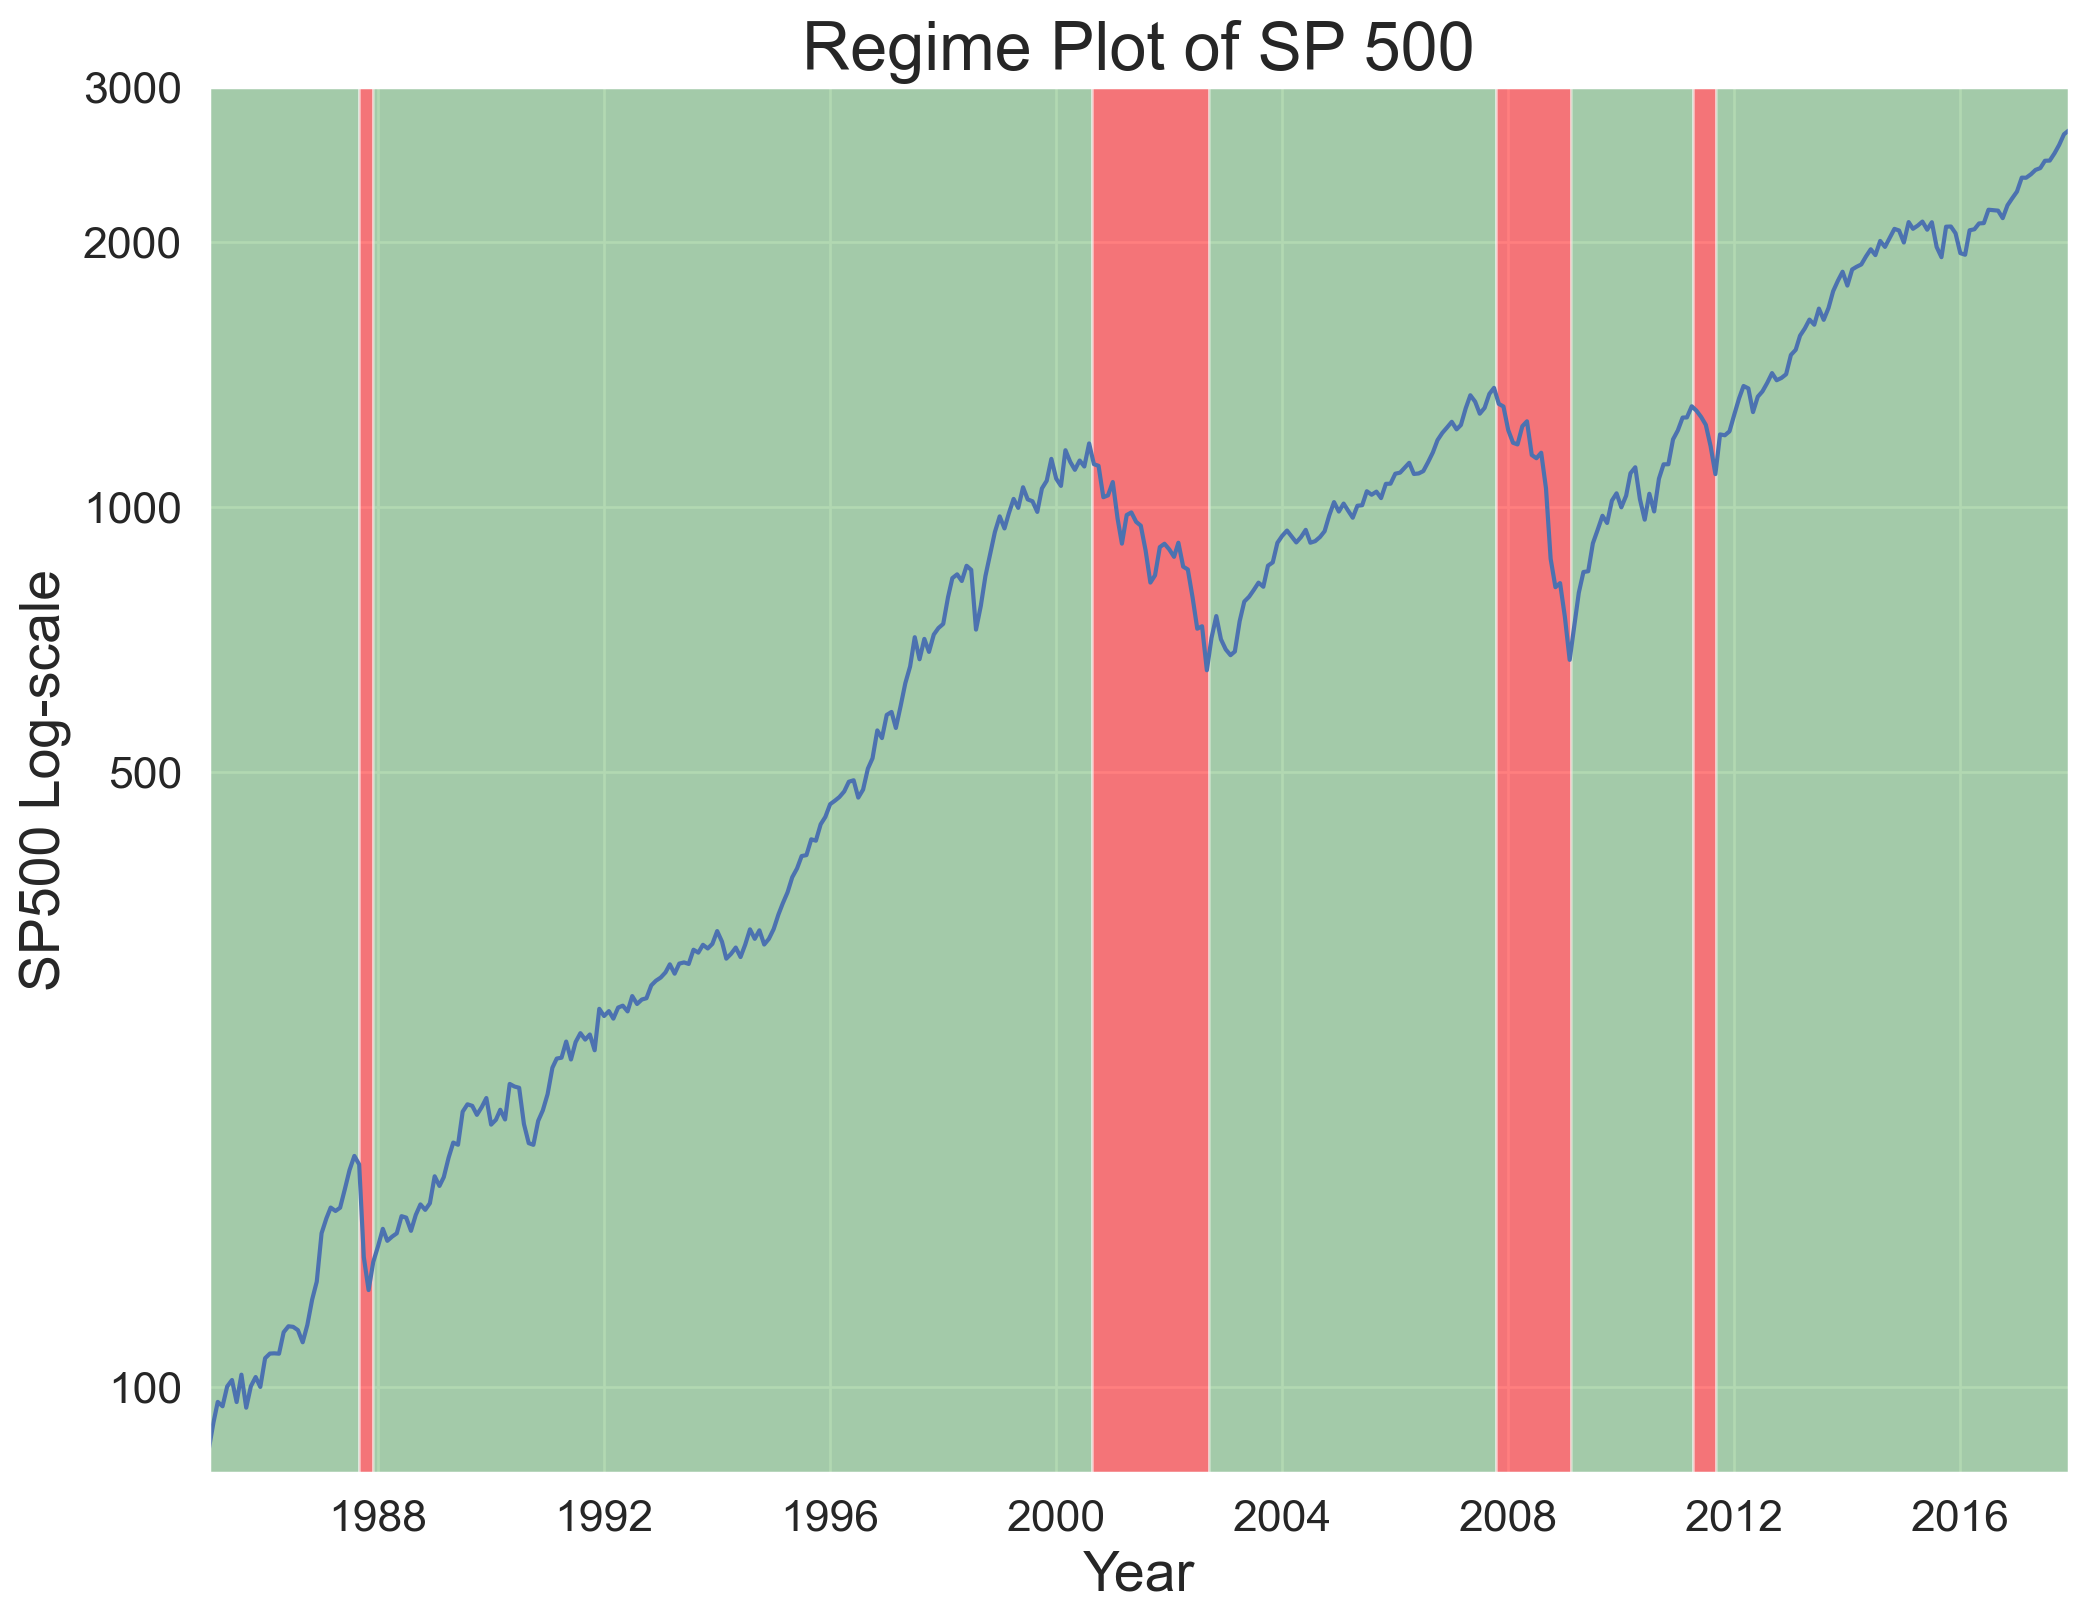

In [11]:
plot_regime_color(SP500_data, lambda_value=16)

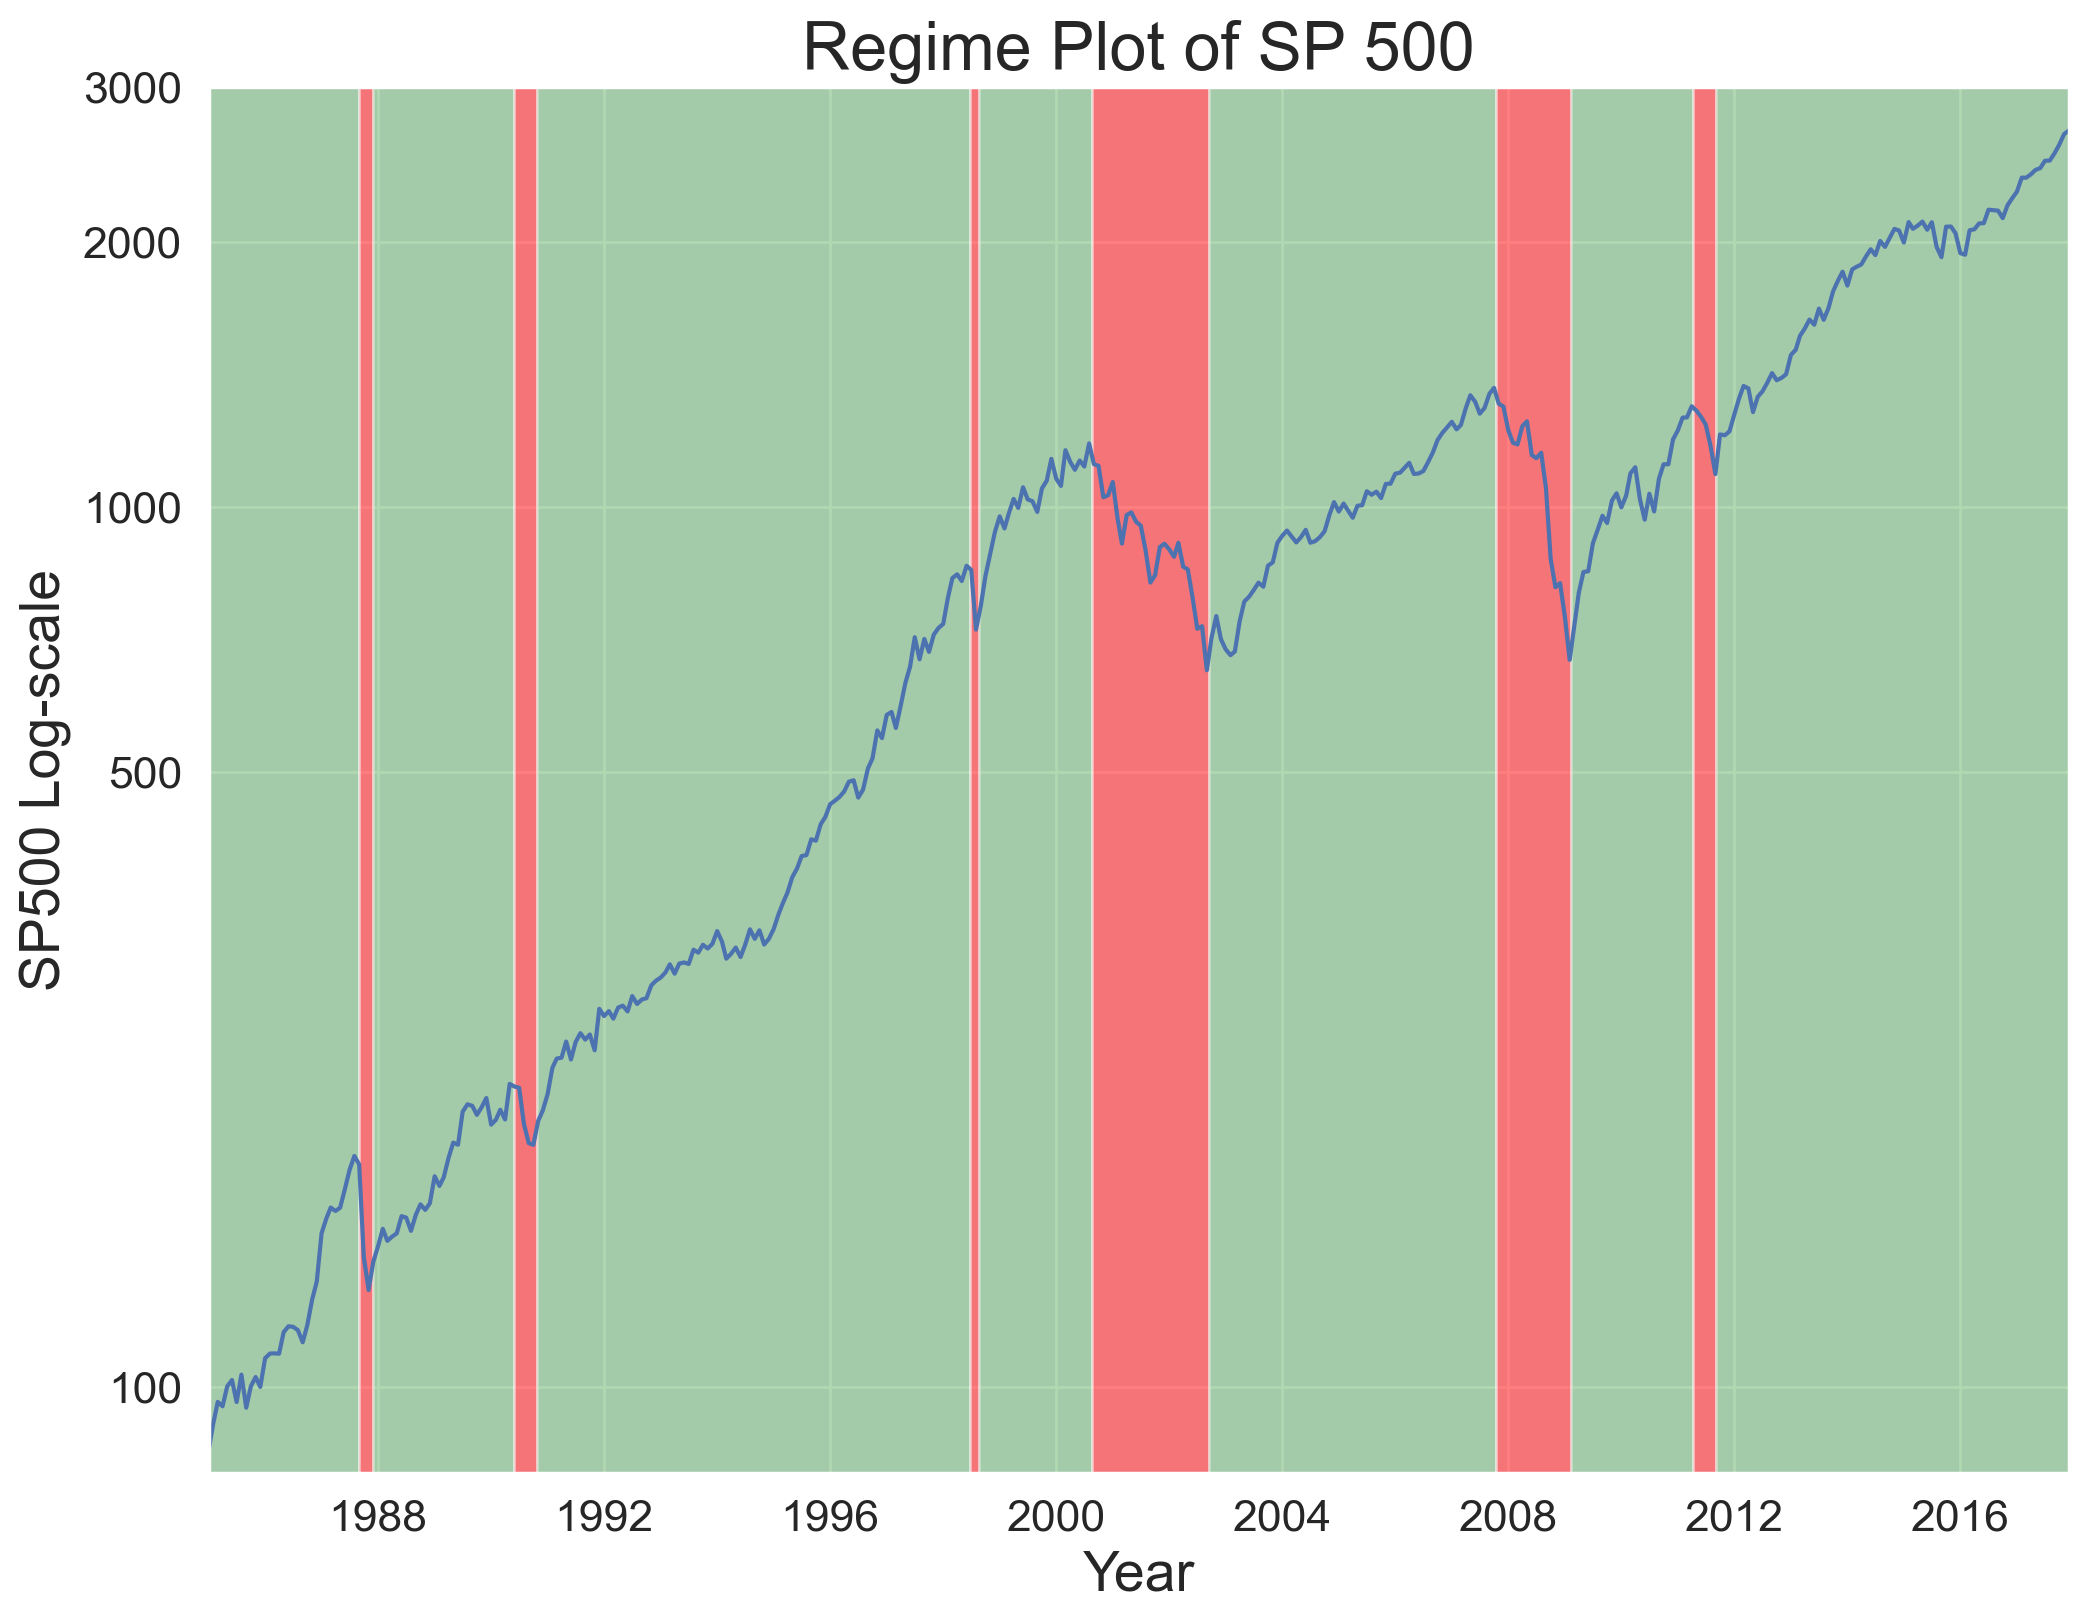

In [12]:
plot_regime_color(SP500_data, lambda_value=14)

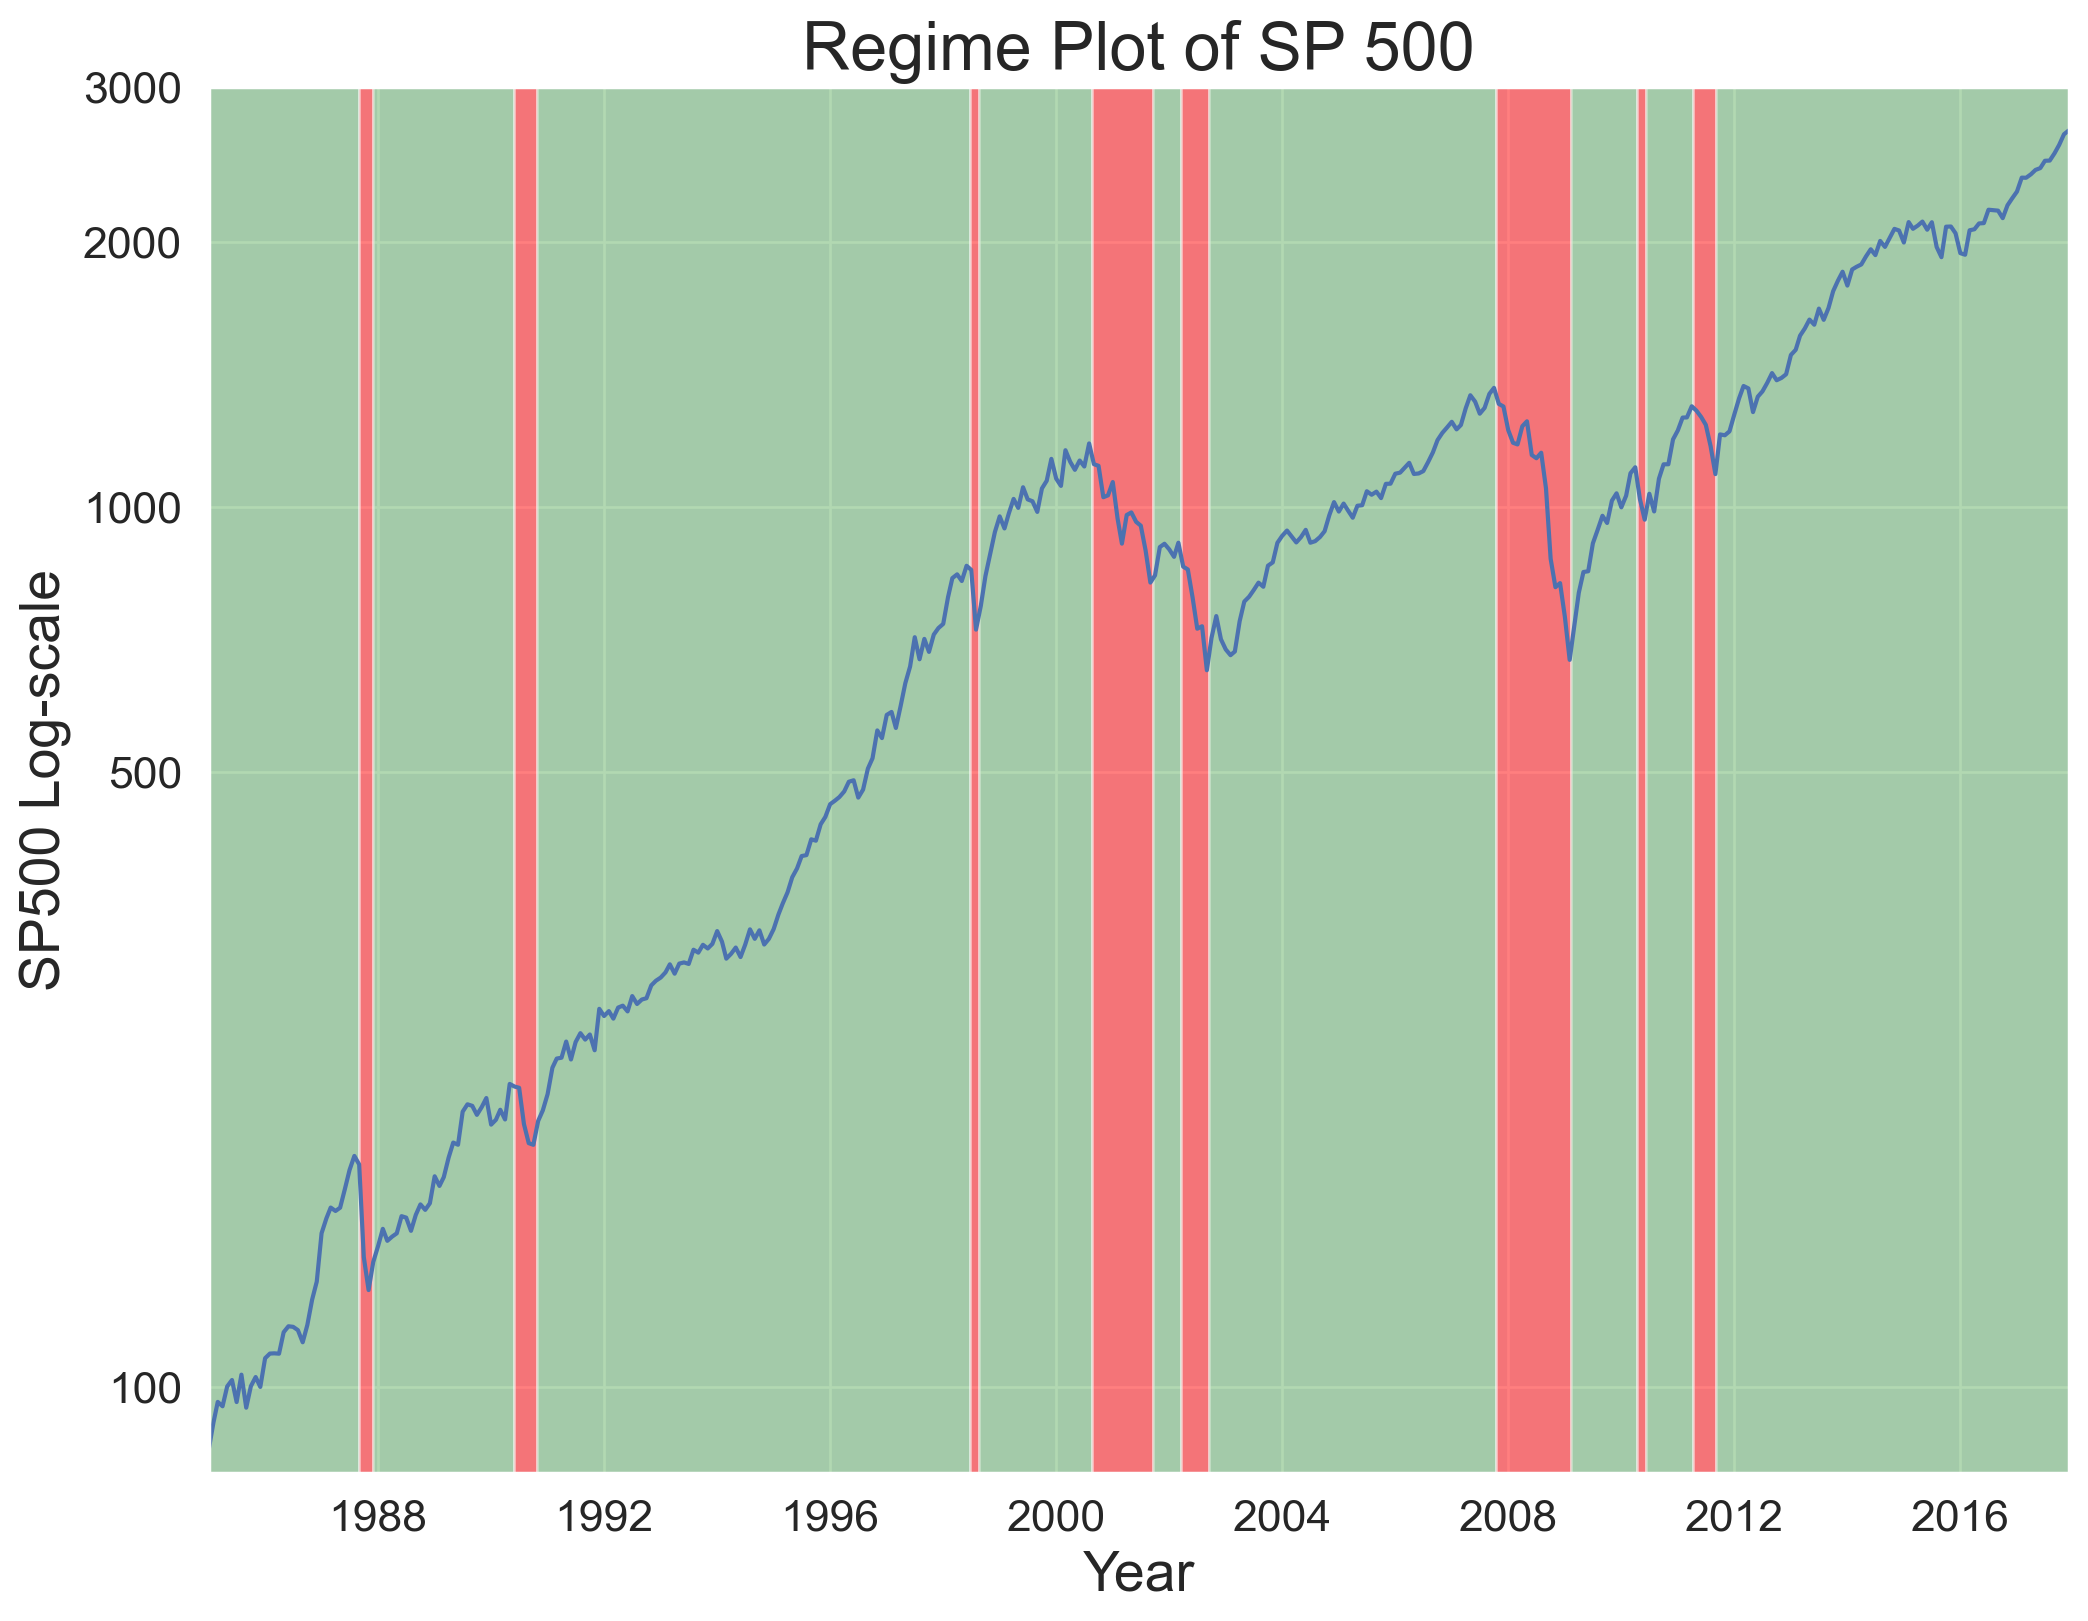

In [13]:
plot_regime_color(SP500_data, lambda_value=10)

## 3. A Regime-based Single Period Model <a class="anchor" id="3"></a>
Here we will deal with the simplest model: we have stocks, bonds and cash.

### 3.1 Regime Identification with the Trend-Filtering Algorithm <a class="anchor" id="3.1"></a>

We have done trend-filtering algorithm in the previous section. Now let's just take the regime from the dataset (column "Regime-5").

### 3.2 Parameter Estimation and Simulation <a class="anchor" id="3.2"></a>



In [14]:
# Set Parameters
n_scen = 10000
m_freq = 12
r_bar = np.arange(0.035,0.115,0.005) # Range of expected returns

In [15]:
Q_all = np.cov(ret.T) * m_freq
r_annual = (1+geo_return(ret)) ** m_freq - 1
r_annual = r_annual.reshape(-1,1)

r_1 = (1+geo_return(ret)) ** m_freq - 1
r_g = (1+geo_return(ret_g)) ** m_freq - 1
r_c = (1+geo_return(ret_c)) ** m_freq - 1
n_g = int(n_scen*ret_g.shape[0] / ret.shape[0])
Q_g = np.cov(ret_g.T) * m_freq
Q_c = np.cov(ret_c.T) * m_freq

In [16]:
# Scenario Equivalent version
r_all_1 = np.random.multivariate_normal(r_1, Q_all, n_scen)

### 3.3 Single-period Portfolio Model <a class="anchor" id="3.3"></a>


c:\Users\jin_x\.conda\envs\finance\lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\jin_x\AppData\Local\Temp\ipykernel_31012\3106796255.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_port[i] = ret_opt.value
c:\Users\jin_x\.conda\envs\finance\lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for mat

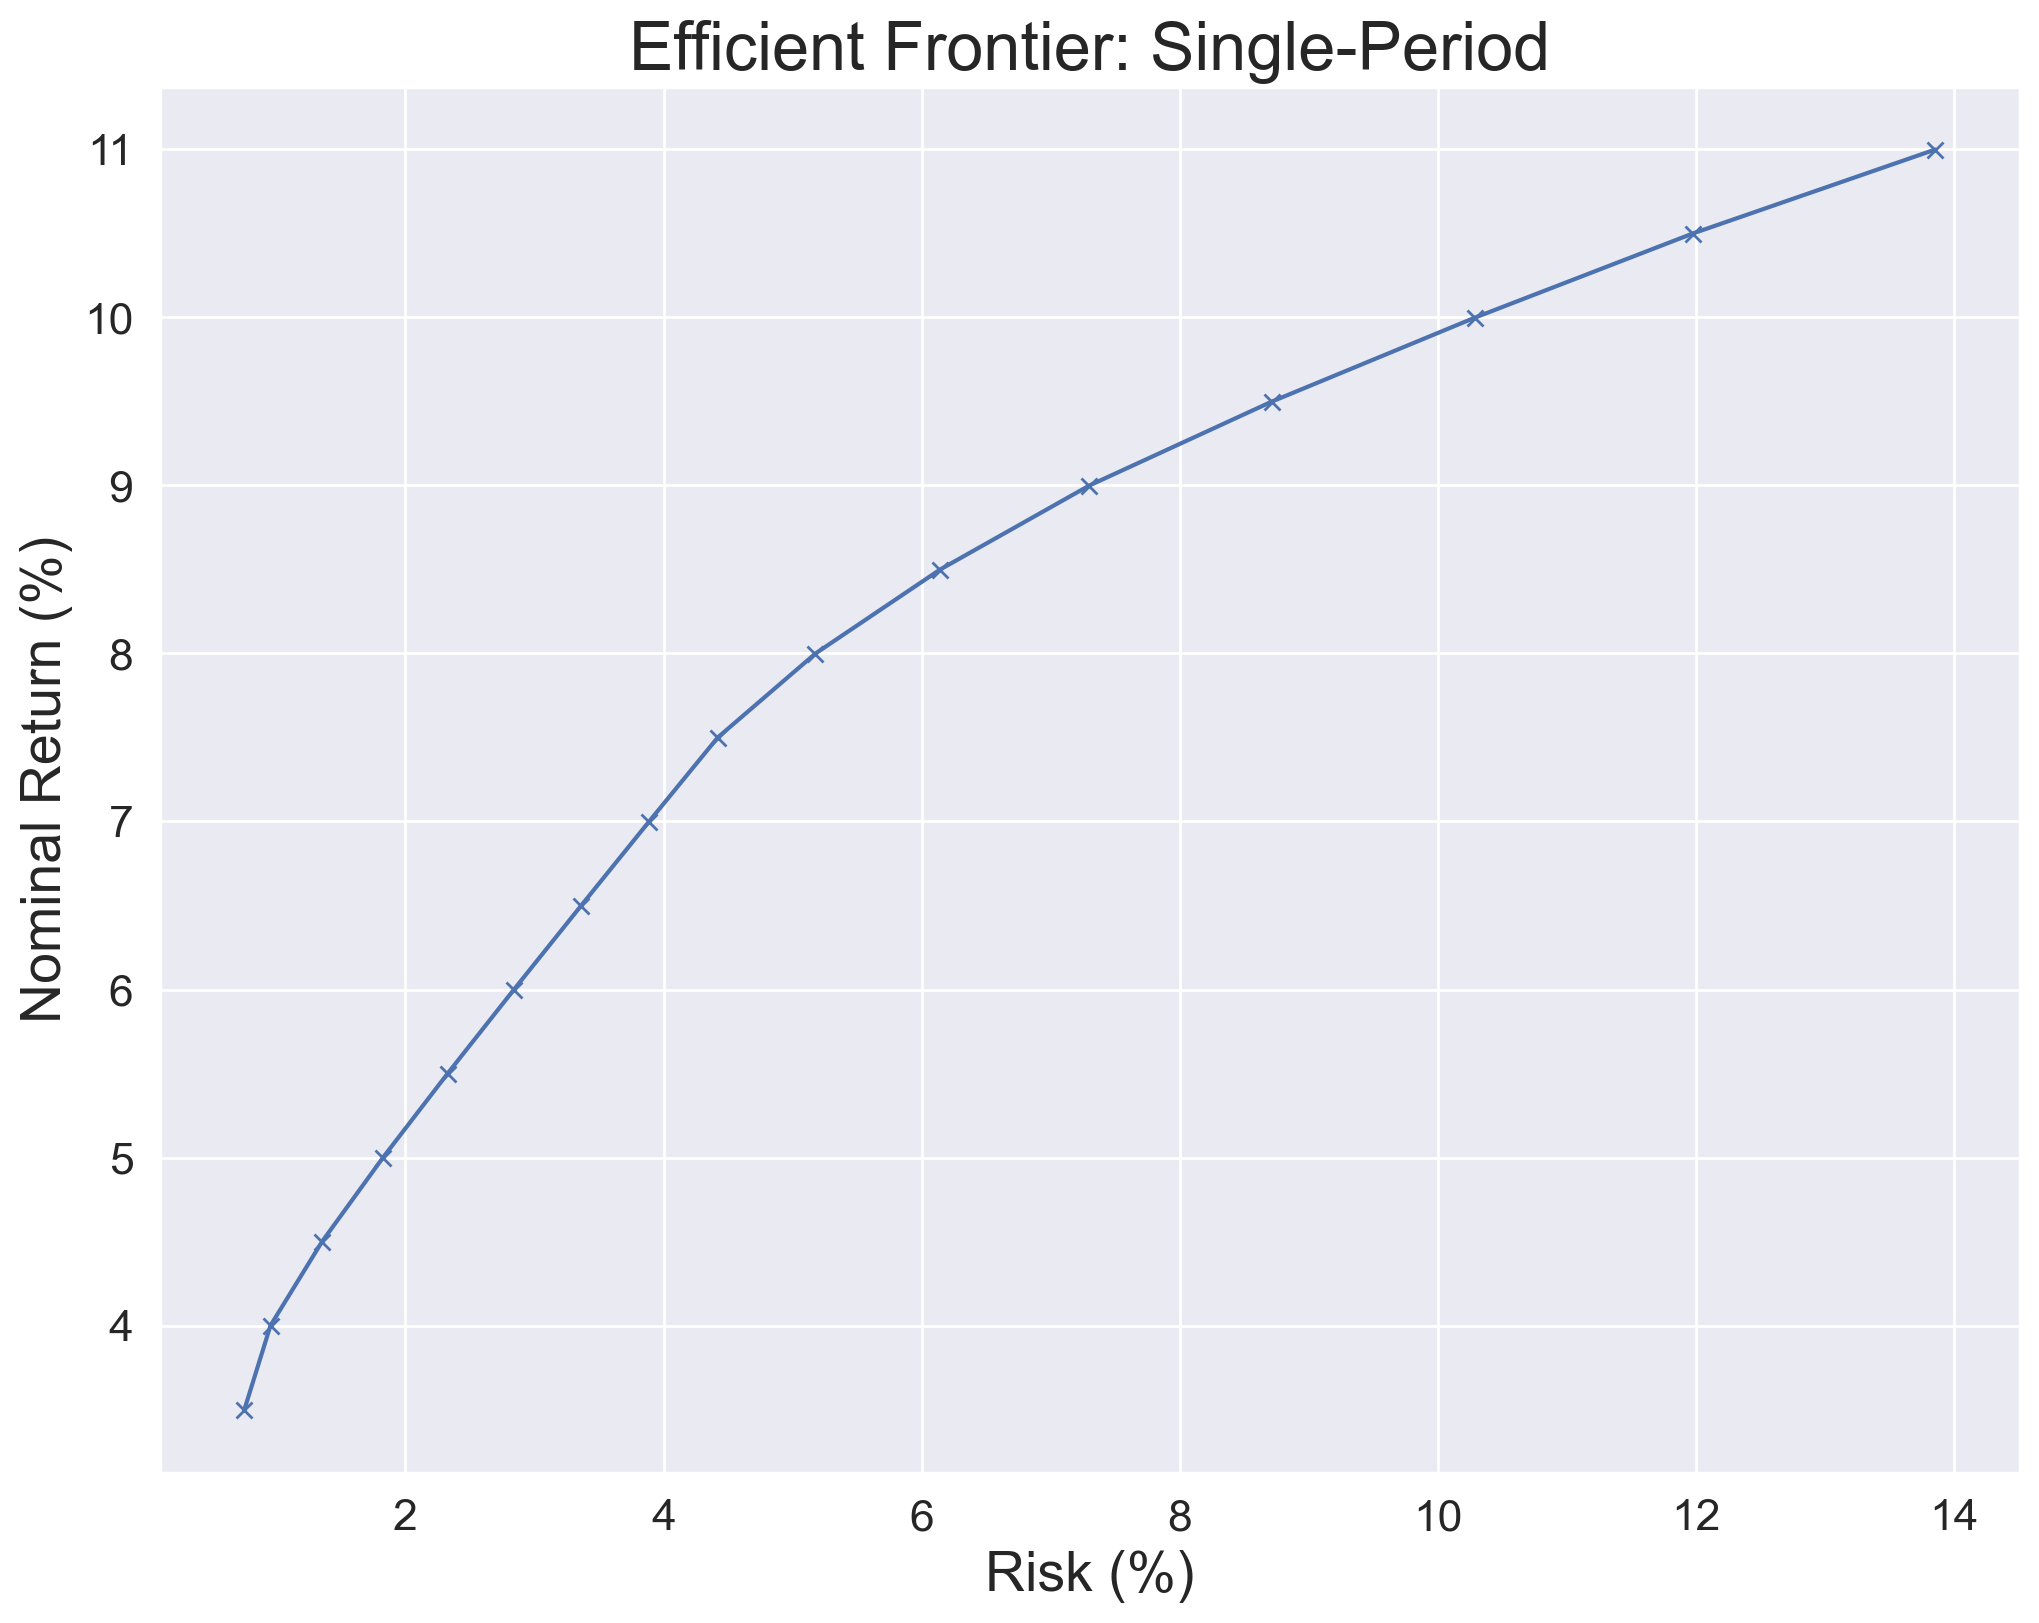

In [17]:
efficient_frontier_traditional(r_annual, Q_all, r_bar)

c:\Users\jin_x\.conda\envs\finance\lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\jin_x\AppData\Local\Temp\ipykernel_31012\3106796255.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_port[i] = ret_opt.value
c:\Users\jin_x\.conda\envs\finance\lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for ma

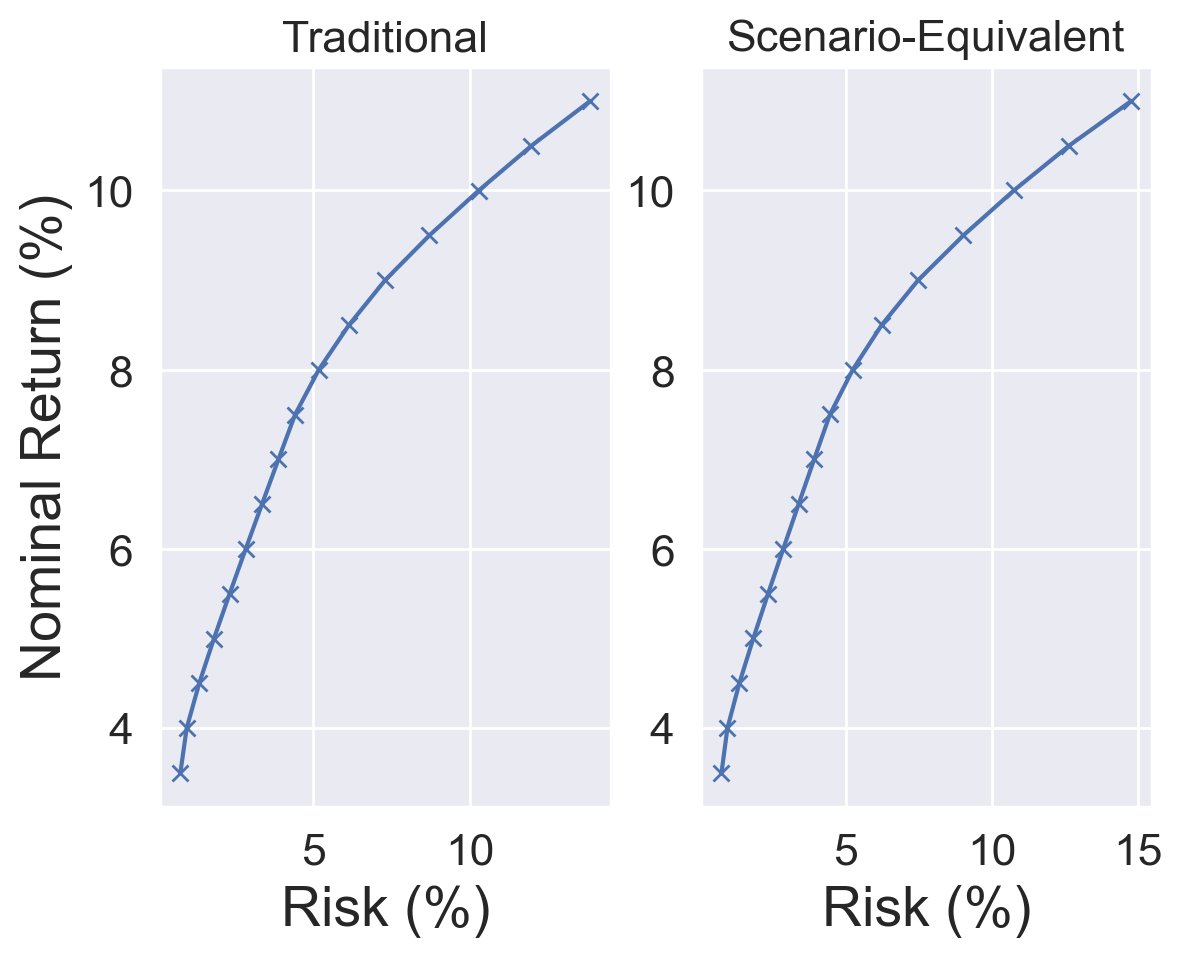

In [18]:
# Compare with scenario equivalent
efficient_frontier_comparison(r_annual, Q_all, r_bar)

### 3.4 Two-regime Simulation

c:\Users\jin_x\.conda\envs\finance\lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 49 times so far.

  warnings.warn(msg, UserWarning)
c:\Users\jin_x\.conda\envs\finance\lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 50 times so far.

  warnings.warn(msg, UserWarning

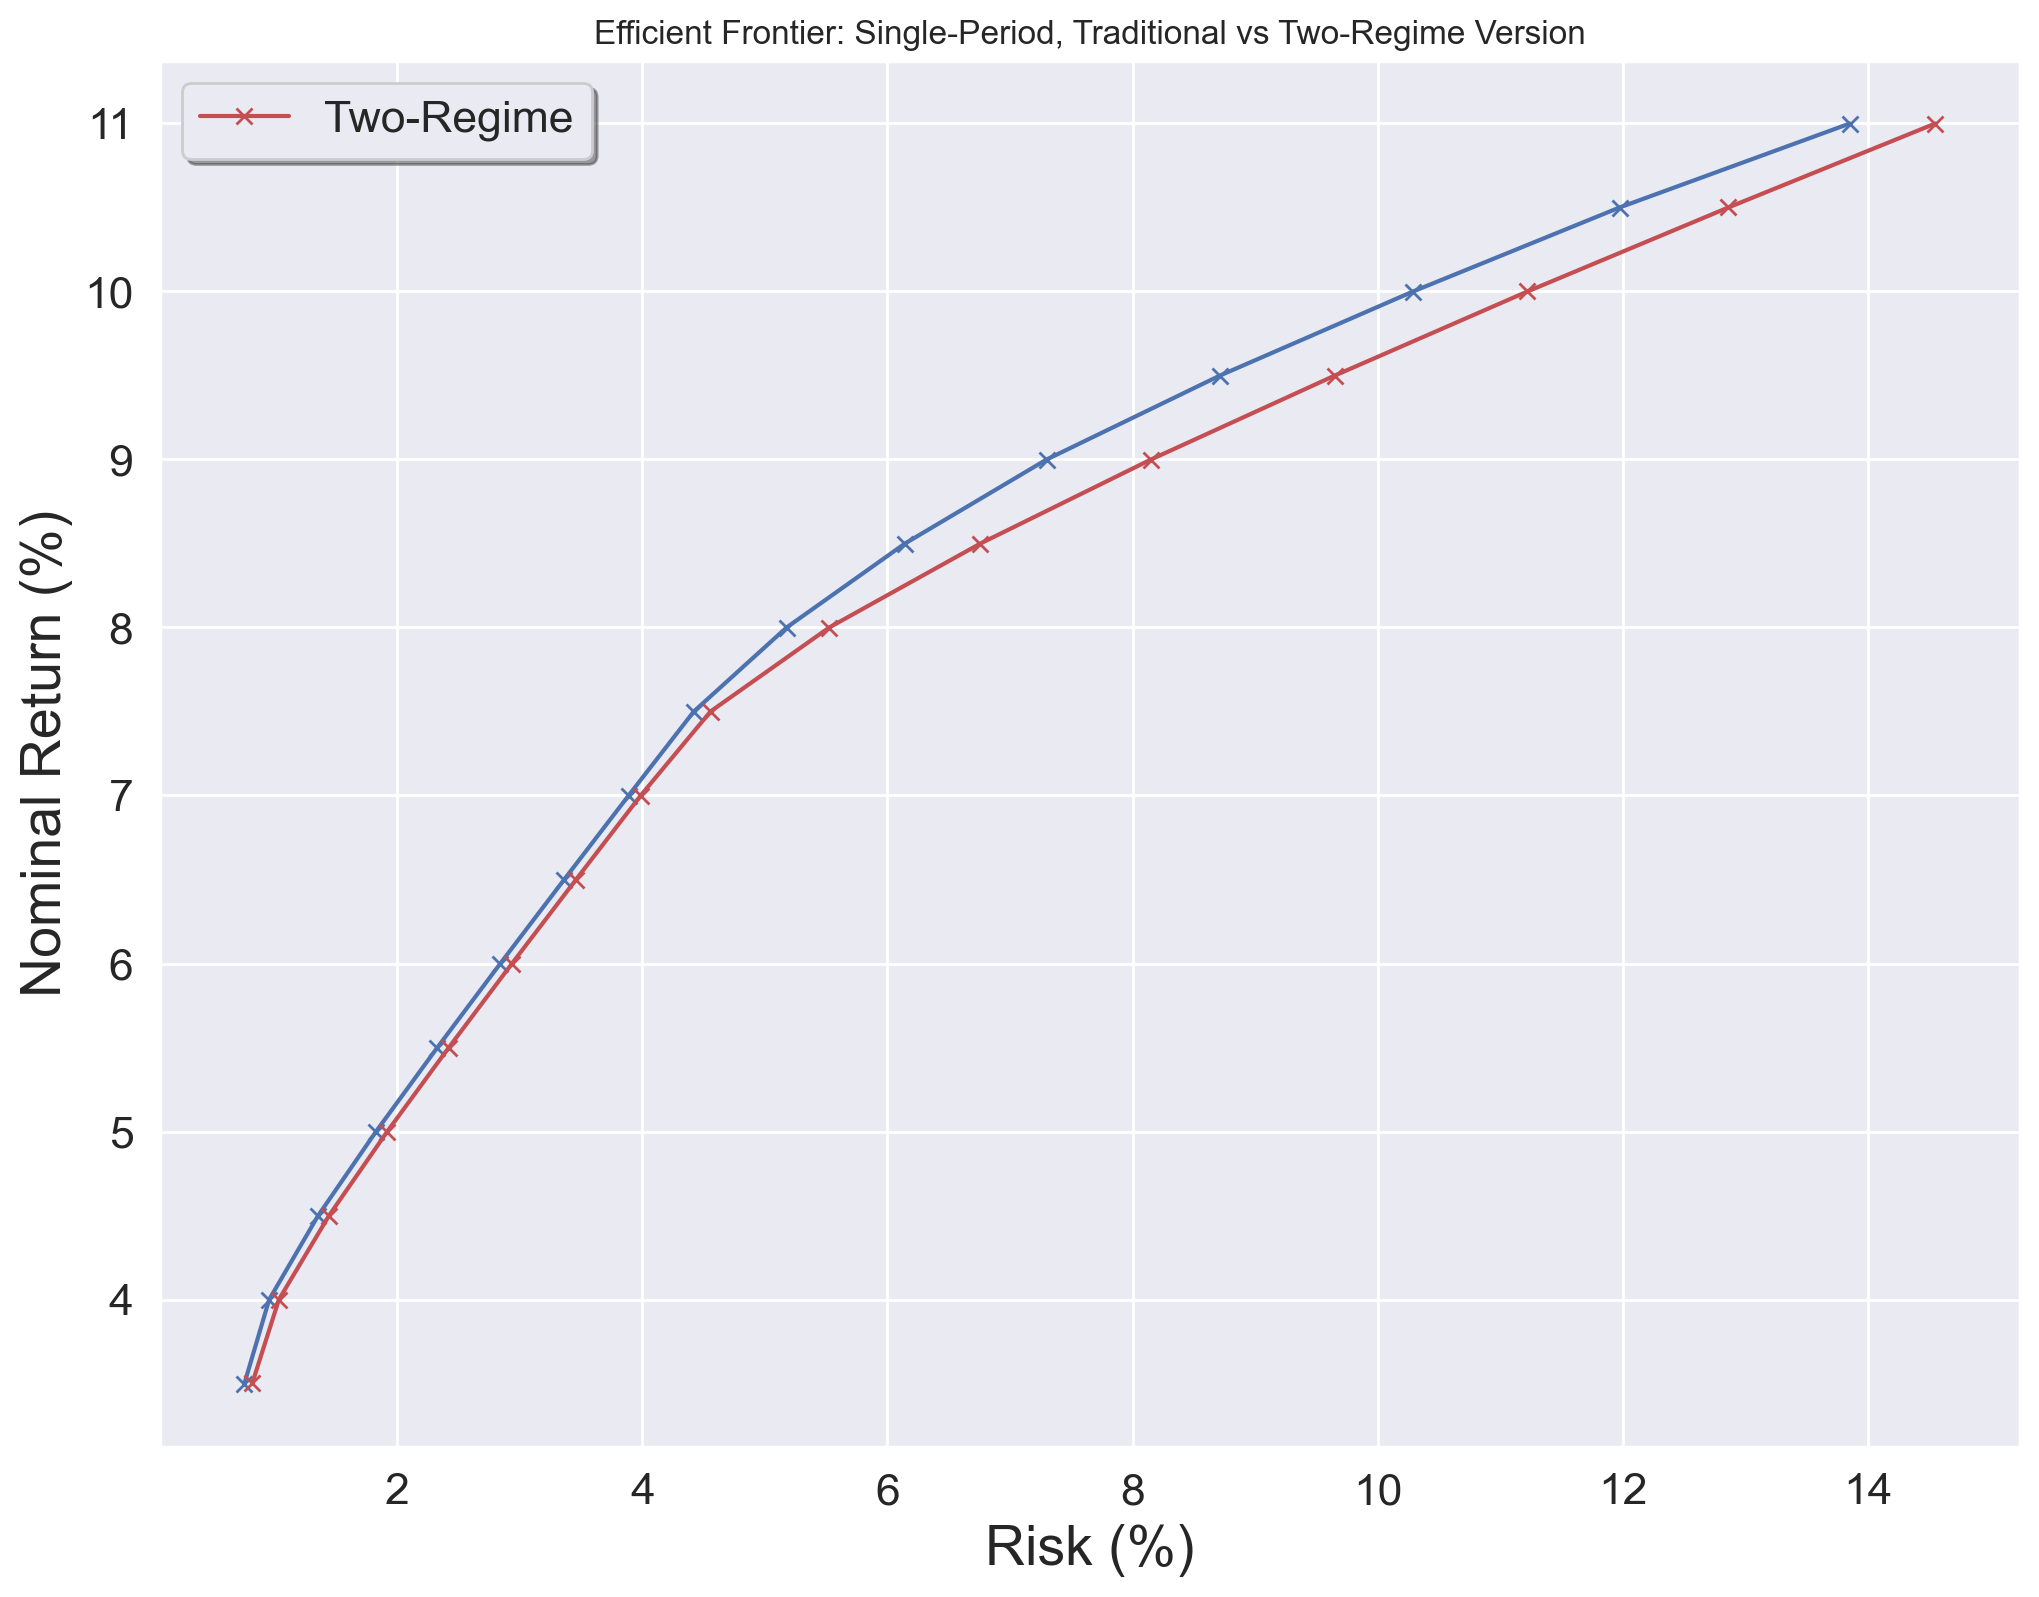

In [19]:
r_all_2 = efficient_frontier_twoRegime(ret, ret_g, ret_c, r_bar)

## 4. Application: Scenario-based Analysis of University Endowment <a class="anchor" id="3"></a>

In [20]:
r_all_50 = asset_simulation(asset_data, asset_num=8,regime_name='Regime-5',random_seed=7,n_scenarios=n_scen)
np.mean(np.mean(r_all_50,axis=0),axis=1)

array([1.00924363, 1.00731724, 1.00513161, 1.00718049, 1.00747885,
       1.0033481 , 1.0060505 , 1.00281213])

In [21]:
holdings = np.array([.3, 0, .2, .2, .1, 0, .15, .05])
result_temp = fund_simulation(holdings, r_all_50, spending_rate=0.07)

In [22]:
# Median Capital after 50 years
np.median(result_temp[:,-1])

np.float64(1.941123610291247)